In [19]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import kagglehub
import pandas as pd
import os

# Download dataset
path = kagglehub.dataset_download("cmglonly/dataset-saham-bank-indonesia-2014-2024")
print("Path to dataset files:", path)

# Simpan dataset ke Google Drive
def save_to_drive(local_path, drive_path):
    # Copy file/folder ke Google Drive
    import shutil
    shutil.copytree(local_path, drive_path, dirs_exist_ok=True)
    print(f"Dataset saved to Google Drive: {drive_path}")

# Path tujuan di Google Drive
drive_dataset_path = '/content/drive/MyDrive/dataset-saham-bank'

# Simpan ke Google Drive
save_to_drive(path, drive_dataset_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using Colab cache for faster access to the 'dataset-saham-bank-indonesia-2014-2024' dataset.
Path to dataset files: /kaggle/input/dataset-saham-bank-indonesia-2014-2024
Dataset saved to Google Drive: /content/drive/MyDrive/dataset-saham-bank


In [20]:
import os
files = os.listdir(path)
files


['BBNI.JK_10_years.csv',
 'BBCA.JK_10_years.csv',
 'BBRI.JK_10_years.csv',
 'BMRI.JK_10_years.csv']

📊 KONSEP OPTIMASI NON-LINEAR UNTUK DATA SAHAM
1. APA ITU OPTIMASI NON-LINEAR?
Optimasi non-linear adalah proses mencari nilai minimum atau maksimum dari fungsi tujuan yang tidak linear (berbentuk kurva, bukan garis lurus).

Dalam konteks saham:

Fungsi Tujuan: Bisa return maksimal, risk minimal, Sharpe ratio maksimal

Variabel: Alokasi portfolio ke masing-masing saham

Constraint: Total alokasi = 100%, batas exposure per saham


2. KOMPONEN UTAMA OPTIMASI

FUNGSI TUJUAN (Objective Function)
   → Apa yang ingin kita optimalkan?
   
PARAMETER/VARIABEL KEPUTUSAN
   → Apa yang bisa kita kontrol?
   
KENDALA (Constraints)
   → Batasan-batasan yang harus dipatuhi


3. Contoh fungsi tujuan untuk saham:


In [21]:
# Mount Google Drive terlebih dahulu
from google.colab import drive
drive.mount('/content/drive')

import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Libraries imported successfully!


In [22]:
# Download dataset
print("Downloading dataset...")
path = kagglehub.dataset_download("cmglonly/dataset-saham-bank-indonesia-2014-2024")
print(f"Dataset downloaded to: {path}")

Using Colab cache for faster access to the 'dataset-saham-bank-indonesia-2014-2024' dataset.
Dataset downloaded to: /kaggle/input/dataset-saham-bank-indonesia-2014-2024


In [23]:
# STEP 1: Load dan Explore Data
def load_and_preprocess_data(path):
    """Load and preprocess stock data"""
    import os
    csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
    print(f"Files found: {csv_files}")

    if csv_files:
        # Load first CSV file
        df = pd.read_csv(os.path.join(path, csv_files[0]))
        print(f"Data shape: {df.shape}")
        print(f"Columns: {df.columns.tolist()}")
        return df
    else:
        raise FileNotFoundError("No CSV files found in dataset")

# Load data
df = load_and_preprocess_data(path)
print("\nFirst 5 rows:")
print(df.head())

Files found: ['BBNI.JK_10_years.csv', 'BBCA.JK_10_years.csv', 'BBRI.JK_10_years.csv', 'BMRI.JK_10_years.csv']
Data shape: (2473, 7)
Columns: ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

First 5 rows:
                        Date    Adj Close   Close    High     Low    Open  \
0  2014-12-08 00:00:00+00:00  2277.288086  2987.5  3100.0  2962.5  3062.5   
1  2014-12-09 00:00:00+00:00  2258.231201  2962.5  3000.0  2950.0  2962.5   
2  2014-12-10 00:00:00+00:00  2296.344727  3012.5  3037.5  2962.5  2962.5   
3  2014-12-11 00:00:00+00:00  2277.288086  2987.5  3012.5  2975.0  2987.5   
4  2014-12-12 00:00:00+00:00  2286.816650  3000.0  3062.5  2975.0  3000.0   

     Volume  
0  64048400  
1  43373200  
2  39428200  
3  52932200  
4  41642800  


In [24]:
# STEP 2: Explore Data Structure secara detail
def explore_data_structure(df):
    """Explore the structure of our stock data"""
    print("=== DETAILED DATA EXPLORATION ===")
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    print(f"\nData types:\n{df.dtypes}")
    print(f"\nMissing values:\n{df.isnull().sum()}")
    print(f"\nBasic statistics:")
    print(df.describe())

    # Cari kolom harga
    price_columns = [col for col in df.columns if any(keyword in col.lower()
                     for keyword in ['close', 'price', 'harga', 'last', 'adj'])]
    print(f"\nPotential price columns: {price_columns}")

    # Cek tipe data tanggal
    date_columns = [col for col in df.columns if any(keyword in col.lower()
                    for keyword in ['date', 'time', 'tanggal', 'periode'])]
    print(f"Potential date columns: {date_columns}")

    return price_columns, date_columns

price_cols, date_cols = explore_data_structure(df)

=== DETAILED DATA EXPLORATION ===
Shape: (2473, 7)
Columns: ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

Data types:
Date          object
Adj Close    float64
Close        float64
High         float64
Low          float64
Open         float64
Volume         int64
dtype: object

Missing values:
Date         0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64

Basic statistics:
         Adj Close        Close         High          Low         Open  \
count  2473.000000  2473.000000  2473.000000  2473.000000  2473.000000   
mean   3243.413883  3691.660938  3737.155277  3647.662758  3694.333805   
std    1028.036779   967.216185   972.972297   960.347621   967.333011   
min    1408.581543  1580.000000  1705.000000  1485.000000  1580.000000   
25%    2324.929932  2800.000000  2837.500000  2762.500000  2800.000000   
50%    3142.642822  3675.000000  3712.500000  3637.500000  3675.000000   
75%    3968.514893  4487.50000

In [25]:
# STEP 3: Prepare Data untuk Optimasi
def prepare_returns_data(df, price_columns=None, date_columns=None):
    """Prepare returns data from price data"""

    # Jika ada kolom tanggal, set sebagai index
    if date_columns and len(date_columns) > 0:
        df = df.copy()
        df[date_columns[0]] = pd.to_datetime(df[date_columns[0]])
        df.set_index(date_columns[0], inplace=True)
        print(f"Set {date_columns[0]} as index")

    if price_columns is None or len(price_columns) == 0:
        # Jika tidak ada kolom harga spesifik, ambil semua kolom numerik
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        price_data = df[numeric_cols]
        print(f"Using all numeric columns: {numeric_cols.tolist()}")
    else:
        price_data = df[price_columns]

    # Hapus kolom dengan semua nilai NaN
    price_data = price_data.dropna(axis=1, how='all')

    # Calculate daily returns
    returns_data = price_data.pct_change().dropna()

    print(f"\nReturns data shape: {returns_data.shape}")
    print(f"Stocks/Assets: {returns_data.columns.tolist()}")
    print(f"Date range: {returns_data.index.min()} to {returns_data.index.max()}")
    print(f"Number of trading days: {len(returns_data)}")

    return returns_data, price_data

# Prepare data
returns_data, price_data = prepare_returns_data(df, price_cols, date_cols)

Set Date as index

Returns data shape: (2472, 2)
Stocks/Assets: ['Adj Close', 'Close']
Date range: 2014-12-09 00:00:00+00:00 to 2024-12-03 00:00:00+00:00
Number of trading days: 2472


In [26]:
# STEP 4: Definisikan Class Optimizer
class PortfolioOptimizer:
    def __init__(self, returns_data):
        self.returns = returns_data
        self.n_assets = len(returns_data.columns)
        print(f"Optimizer initialized with {self.n_assets} assets")

    # FUNGSI TUJUAN 1: MINIMIZE RISK (VOLATILITY)
    def portfolio_volatility(self, weights):
        """Calculate portfolio volatility"""
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(self.returns.cov(), weights)))
        return portfolio_volatility

    # FUNGSI TUJUAN 2: MAXIMIZE SHARPE RATIO
    def negative_sharpe_ratio(self, weights, risk_free_rate=0.02/252):  # Daily risk-free rate
        """Negative Sharpe ratio (for minimization)"""
        portfolio_return = np.dot(weights, self.returns.mean())
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(self.returns.cov(), weights)))

        if portfolio_volatility == 0:
            return 1e10  # Large number for failed optimization

        sharpe = (portfolio_return - risk_free_rate) / portfolio_volatility
        return -sharpe  # Negative because we minimize

    # FUNGSI TUJUAN 3: MAXIMIZE RETURN
    def negative_portfolio_return(self, weights):
        """Negative portfolio return (for minimization)"""
        portfolio_return = np.dot(weights, self.returns.mean())
        return -portfolio_return

    # CONSTRAINTS & BOUNDS
    def get_constraints(self):
        """Sum of weights = 1"""
        return ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    def get_bounds(self):
        """Each weight between 0 and 1 (no short selling)"""
        return [(0, 1) for _ in range(self.n_assets)]

In [27]:
# STEP 5: Fungsi Optimasi
def find_optimal_weights(returns_data, objective_function, initial_guess=None):
    """Find optimal portfolio weights"""
    optimizer = PortfolioOptimizer(returns_data)

    if initial_guess is None:
        initial_guess = np.array([1/returns_data.shape[1]] * returns_data.shape[1])

    # Optimize
    result = minimize(
        fun=objective_function,
        x0=initial_guess,
        method='SLSQP',
        bounds=optimizer.get_bounds(),
        constraints=optimizer.get_constraints(),
        options={'ftol': 1e-10, 'disp': False}
    )

    return result, optimizer

# Test dengan satu objective dulu
print("=== TESTING OPTIMIZATION ===")
optimizer_test = PortfolioOptimizer(returns_data)

# Optimize untuk minimum risk
result_min_risk, optimizer = find_optimal_weights(
    returns_data,
    optimizer_test.portfolio_volatility
)

print(f"Optimization successful: {result_min_risk.success}")
if result_min_risk.success:
    print(f"Optimal weights: {result_min_risk.x}")
    print(f"Minimum volatility: {result_min_risk.fun:.6f}")

    # Calculate corresponding return
    optimal_return = np.dot(result_min_risk.x, returns_data.mean())
    print(f"Expected return: {optimal_return:.6f}")
else:
    print(f"Optimization failed: {result_min_risk.message}")

=== TESTING OPTIMIZATION ===
Optimizer initialized with 2 assets
Optimizer initialized with 2 assets
Optimization successful: True
Optimal weights: [1.00000000e+00 5.55111512e-17]
Minimum volatility: 0.020323
Expected return: 0.000506


In [28]:
# STEP 6: Compare Multiple Objectives
def compare_objectives(returns_data):
    """Compare different optimization objectives"""
    optimizer = PortfolioOptimizer(returns_data)

    objectives = {
        'Minimize Risk': optimizer.portfolio_volatility,
        'Maximize Sharpe': optimizer.negative_sharpe_ratio,
        'Maximize Return': optimizer.negative_portfolio_return
    }

    results = {}
    for name, objective in objectives.items():
        print(f"\n{'='*50}")
        print(f"OPTIMIZING: {name}")
        print(f"{'='*50}")

        result, _ = find_optimal_weights(returns_data, objective)

        if result.success:
            optimal_weights = result.x
            portfolio_return = np.dot(optimal_weights, returns_data.mean())
            portfolio_risk = np.sqrt(np.dot(optimal_weights.T, np.dot(returns_data.cov(), optimal_weights)))

            # Annualize returns and risk (assuming 252 trading days)
            annual_return = portfolio_return * 252
            annual_risk = portfolio_risk * np.sqrt(252)
            sharpe = (annual_return - 0.02) / annual_risk if annual_risk > 0 else 0

            results[name] = {
                'weights': optimal_weights,
                'daily_return': portfolio_return,
                'daily_risk': portfolio_risk,
                'annual_return': annual_return,
                'annual_risk': annual_risk,
                'sharpe': sharpe,
                'objective_value': result.fun
            }

            print(f"✅ Optimization SUCCESSFUL")
            print(f"Annual Return: {annual_return:.4f} ({annual_return*100:.2f}%)")
            print(f"Annual Risk: {annual_risk:.4f} ({annual_risk*100:.2f}%)")
            print(f"Sharpe Ratio: {sharpe:.4f}")
            print(f"Objective Value: {result.fun:.6f}")

            # Print weights for each stock
            print("\nOptimal Weights:")
            for i, stock in enumerate(returns_data.columns):
                print(f"  {stock}: {optimal_weights[i]:.4f} ({optimal_weights[i]*100:.2f}%)")

            # Check sum of weights
            print(f"Sum of weights: {np.sum(optimal_weights):.6f}")
        else:
            print(f"❌ Optimization FAILED: {result.message}")
            results[name] = None

    return results

# Run comparison
print("🚀 STARTING COMPREHENSIVE OPTIMIZATION ANALYSIS")
results = compare_objectives(returns_data)

🚀 STARTING COMPREHENSIVE OPTIMIZATION ANALYSIS
Optimizer initialized with 2 assets

OPTIMIZING: Minimize Risk
Optimizer initialized with 2 assets
✅ Optimization SUCCESSFUL
Annual Return: 0.1275 (12.75%)
Annual Risk: 0.3226 (32.26%)
Sharpe Ratio: 0.3331
Objective Value: 0.020323

Optimal Weights:
  Adj Close: 1.0000 (100.00%)
  Close: 0.0000 (0.00%)
Sum of weights: 1.000000

OPTIMIZING: Maximize Sharpe
Optimizer initialized with 2 assets
✅ Optimization SUCCESSFUL
Annual Return: 0.1275 (12.75%)
Annual Risk: 0.3226 (32.26%)
Sharpe Ratio: 0.3331
Objective Value: -0.020981

Optimal Weights:
  Adj Close: 1.0000 (100.00%)
  Close: 0.0000 (0.00%)
Sum of weights: 1.000000

OPTIMIZING: Maximize Return
Optimizer initialized with 2 assets
✅ Optimization SUCCESSFUL
Annual Return: 0.1275 (12.75%)
Annual Risk: 0.3226 (32.26%)
Sharpe Ratio: 0.3331
Objective Value: -0.000506

Optimal Weights:
  Adj Close: 1.0000 (100.00%)
  Close: 0.0000 (0.00%)
Sum of weights: 1.000000



📊 GENERATING VISUALIZATIONS...


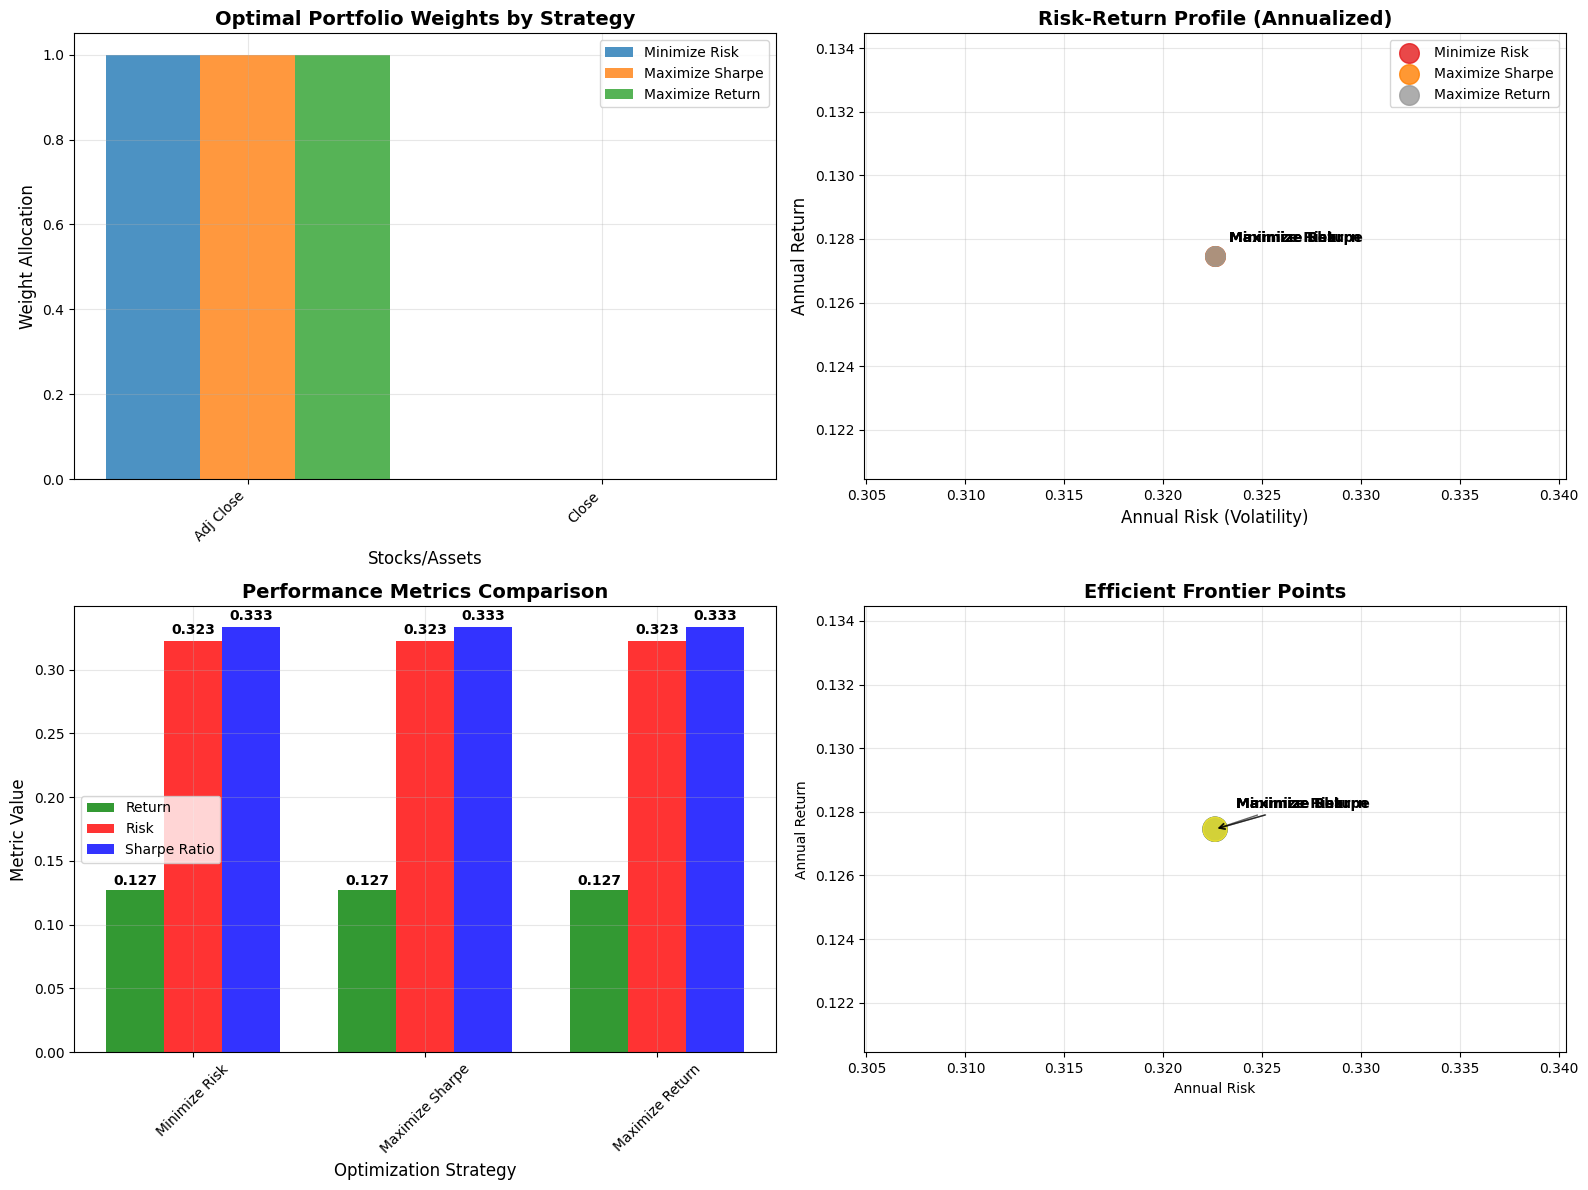

In [29]:
# STEP 7: Visualisasi Hasil
def visualize_results(results, returns_data):
    """Visualize optimization results"""

    # Filter hanya results yang sukses
    successful_results = {k: v for k, v in results.items() if v is not None}

    if not successful_results:
        print("No successful optimizations to visualize")
        return

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    strategies = list(successful_results.keys())
    stocks = returns_data.columns

    # Plot 1: Portfolio Weights Comparison
    bar_width = 0.8 / len(strategies)
    for i, strategy in enumerate(strategies):
        positions = np.arange(len(stocks)) + i * bar_width
        ax1.bar(positions, successful_results[strategy]['weights'],
                width=bar_width, label=strategy, alpha=0.8)

    ax1.set_title('Optimal Portfolio Weights by Strategy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Stocks/Assets', fontsize=12)
    ax1.set_ylabel('Weight Allocation', fontsize=12)
    ax1.set_xticks(np.arange(len(stocks)) + bar_width * (len(strategies)-1)/2)
    ax1.set_xticklabels(stocks, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Risk-Return Profile (Annualized)
    colors = plt.cm.Set1(np.linspace(0, 1, len(strategies)))
    for i, strategy in enumerate(strategies):
        ax2.scatter(successful_results[strategy]['annual_risk'],
                   successful_results[strategy]['annual_return'],
                   s=200, c=[colors[i]], label=strategy, alpha=0.8)
        ax2.annotate(strategy,
                    (successful_results[strategy]['annual_risk'],
                     successful_results[strategy]['annual_return']),
                    xytext=(10, 10), textcoords='offset points',
                    fontweight='bold')

    ax2.set_title('Risk-Return Profile (Annualized)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Annual Risk (Volatility)', fontsize=12)
    ax2.set_ylabel('Annual Return', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: Performance Metrics Comparison
    metrics = ['annual_return', 'annual_risk', 'sharpe']
    metric_names = ['Return', 'Risk', 'Sharpe Ratio']
    metric_colors = ['green', 'red', 'blue']

    x_pos = np.arange(len(strategies))
    width = 0.25

    for i, (metric, name, color) in enumerate(zip(metrics, metric_names, metric_colors)):
        values = [successful_results[strategy][metric] for strategy in strategies]
        bars = ax3.bar(x_pos + i * width, values, width, label=name, color=color, alpha=0.8)

        # Add value labels on bars
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01 * max(values),
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    ax3.set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Optimization Strategy', fontsize=12)
    ax3.set_ylabel('Metric Value', fontsize=12)
    ax3.set_xticks(x_pos + width)
    ax3.set_xticklabels(strategies, rotation=45)
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: Efficient Frontier (simplified)
    risks = [successful_results[strategy]['annual_risk'] for strategy in strategies]
    returns = [successful_results[strategy]['annual_return'] for strategy in strategies]

    scatter = ax4.scatter(risks, returns, c=range(len(strategies)),
                         cmap='viridis', s=300, alpha=0.8)

    # Add labels
    for i, strategy in enumerate(strategies):
        ax4.annotate(strategy, (risks[i], returns[i]),
                    xytext=(15, 15), textcoords='offset points',
                    fontweight='bold',
                    arrowprops=dict(arrowstyle='->', color='black', alpha=0.6))

    ax4.set_title('Efficient Frontier Points', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Annual Risk')
    ax4.set_ylabel('Annual Return')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Visualize results
print("\n📊 GENERATING VISUALIZATIONS...")
visualize_results(results, returns_data)

=== INDIVIDUAL ASSET ANALYSIS ===
           Annual Return  Annual Volatility  Sharpe Ratio
Adj Close       0.127452           0.322619      0.333061
Close           0.100240           0.324011      0.247646


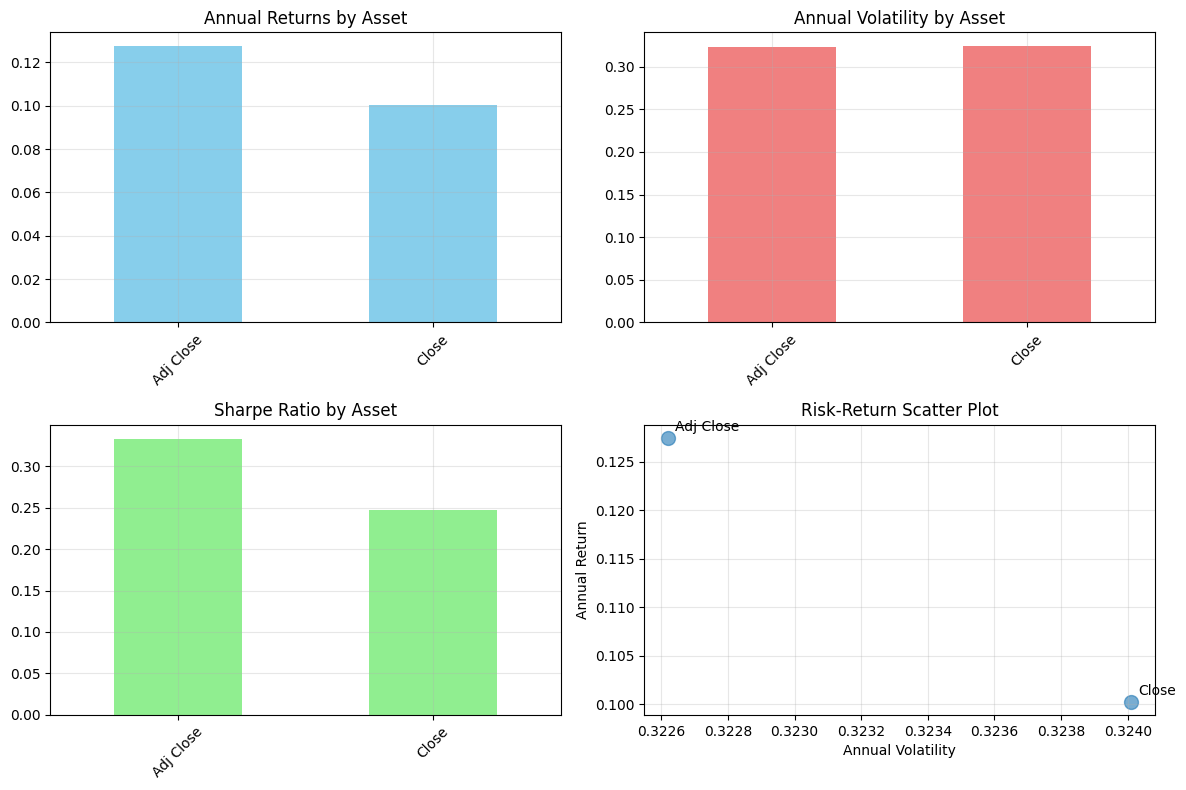

In [30]:
# STEP 8: Analisis Tambahan - Performance Individual Assets
def analyze_individual_assets(returns_data):
    """Analyze individual asset performance"""
    print("=== INDIVIDUAL ASSET ANALYSIS ===")

    annual_returns = returns_data.mean() * 252
    annual_volatility = returns_data.std() * np.sqrt(252)
    sharpe_ratios = (annual_returns - 0.02) / annual_volatility

    performance_df = pd.DataFrame({
        'Annual Return': annual_returns,
        'Annual Volatility': annual_volatility,
        'Sharpe Ratio': sharpe_ratios
    }).sort_values('Sharpe Ratio', ascending=False)

    print(performance_df)

    # Visualize individual assets
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    performance_df['Annual Return'].plot(kind='bar', color='skyblue')
    plt.title('Annual Returns by Asset')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 2)
    performance_df['Annual Volatility'].plot(kind='bar', color='lightcoral')
    plt.title('Annual Volatility by Asset')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 3)
    performance_df['Sharpe Ratio'].plot(kind='bar', color='lightgreen')
    plt.title('Sharpe Ratio by Asset')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 4)
    plt.scatter(performance_df['Annual Volatility'], performance_df['Annual Return'],
               s=100, alpha=0.6)
    for i, asset in enumerate(performance_df.index):
        plt.annotate(asset, (performance_df['Annual Volatility'].iloc[i],
                           performance_df['Annual Return'].iloc[i]),
                   xytext=(5, 5), textcoords='offset points')
    plt.xlabel('Annual Volatility')
    plt.ylabel('Annual Return')
    plt.title('Risk-Return Scatter Plot')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return performance_df

# Analyze individual assets
performance_df = analyze_individual_assets(returns_data)

In [31]:
# STEP 9: Summary dan Rekomendasi
def generate_recommendations(results, performance_df):
    """Generate investment recommendations"""
    print("🎯 INVESTMENT RECOMMENDATIONS")
    print("=" * 50)

    successful_results = {k: v for k, v in results.items() if v is not None}

    if not successful_results:
        print("No successful optimizations for recommendations")
        return

    # Find best strategy based on Sharpe ratio
    best_sharpe_strategy = max(successful_results.items(),
                              key=lambda x: x[1]['sharpe'])

    best_return_strategy = max(successful_results.items(),
                              key=lambda x: x[1]['annual_return'])

    best_risk_strategy = min(successful_results.items(),
                            key=lambda x: x[1]['annual_risk'])

    print(f"\n📈 BEST SHARPE RATIO: {best_sharpe_strategy[0]}")
    print(f"   Sharpe Ratio: {best_sharpe_strategy[1]['sharpe']:.4f}")
    print(f"   Return: {best_sharpe_strategy[1]['annual_return']:.4f} ({best_sharpe_strategy[1]['annual_return']*100:.2f}%)")
    print(f"   Risk: {best_sharpe_strategy[1]['annual_risk']:.4f} ({best_sharpe_strategy[1]['annual_risk']*100:.2f}%)")

    print(f"\n💰 HIGHEST RETURN: {best_return_strategy[0]}")
    print(f"   Return: {best_return_strategy[1]['annual_return']:.4f} ({best_return_strategy[1]['annual_return']*100:.2f}%)")
    print(f"   Risk: {best_return_strategy[1]['annual_risk']:.4f} ({best_return_strategy[1]['annual_risk']*100:.2f}%)")

    print(f"\n🛡️ LOWEST RISK: {best_risk_strategy[0]}")
    print(f"   Risk: {best_risk_strategy[1]['annual_risk']:.4f} ({best_risk_strategy[1]['annual_risk']*100:.2f}%)")
    print(f"   Return: {best_risk_strategy[1]['annual_return']:.4f} ({best_risk_strategy[1]['annual_return']*100:.2f}%)")

    print(f"\n🏆 TOP PERFORMING INDIVIDUAL ASSETS:")
    top_assets = performance_df.head(3)
    for i, (asset, row) in enumerate(top_assets.iterrows(), 1):
        print(f"   {i}. {asset}:")
        print(f"      Sharpe: {row['Sharpe Ratio']:.4f}")
        print(f"      Return: {row['Annual Return']:.4f} ({row['Annual Return']*100:.2f}%)")
        print(f"      Volatility: {row['Annual Volatility']:.4f} ({row['Annual Volatility']*100:.2f}%)")

# Generate recommendations
generate_recommendations(results, performance_df)

🎯 INVESTMENT RECOMMENDATIONS

📈 BEST SHARPE RATIO: Minimize Risk
   Sharpe Ratio: 0.3331
   Return: 0.1275 (12.75%)
   Risk: 0.3226 (32.26%)

💰 HIGHEST RETURN: Minimize Risk
   Return: 0.1275 (12.75%)
   Risk: 0.3226 (32.26%)

🛡️ LOWEST RISK: Minimize Risk
   Risk: 0.3226 (32.26%)
   Return: 0.1275 (12.75%)

🏆 TOP PERFORMING INDIVIDUAL ASSETS:
   1. Adj Close:
      Sharpe: 0.3331
      Return: 0.1275 (12.75%)
      Volatility: 0.3226 (32.26%)
   2. Close:
      Sharpe: 0.2476
      Return: 0.1002 (10.02%)
      Volatility: 0.3240 (32.40%)


=== DEEP DATA ANALYSIS ===
📊 Dataset Shape: (2473, 2)
📅 Time Period: 2014-12-08 00:00:00+00:00 to 2024-12-03 00:00:00+00:00
🏦 Number of Banks/Assets: 2

📈 Descriptive Statistics:
         Adj Close        Close
count  2473.000000  2473.000000
mean   3243.413883  3691.660938
std    1028.036779   967.216185
min    1408.581543  1580.000000
25%    2324.929932  2800.000000
50%    3142.642822  3675.000000
75%    3968.514893  4487.500000
max    5950.000000  6225.000000

🔗 Correlation Matrix:
           Adj Close     Close
Adj Close   1.000000  0.979207
Close       0.979207  1.000000


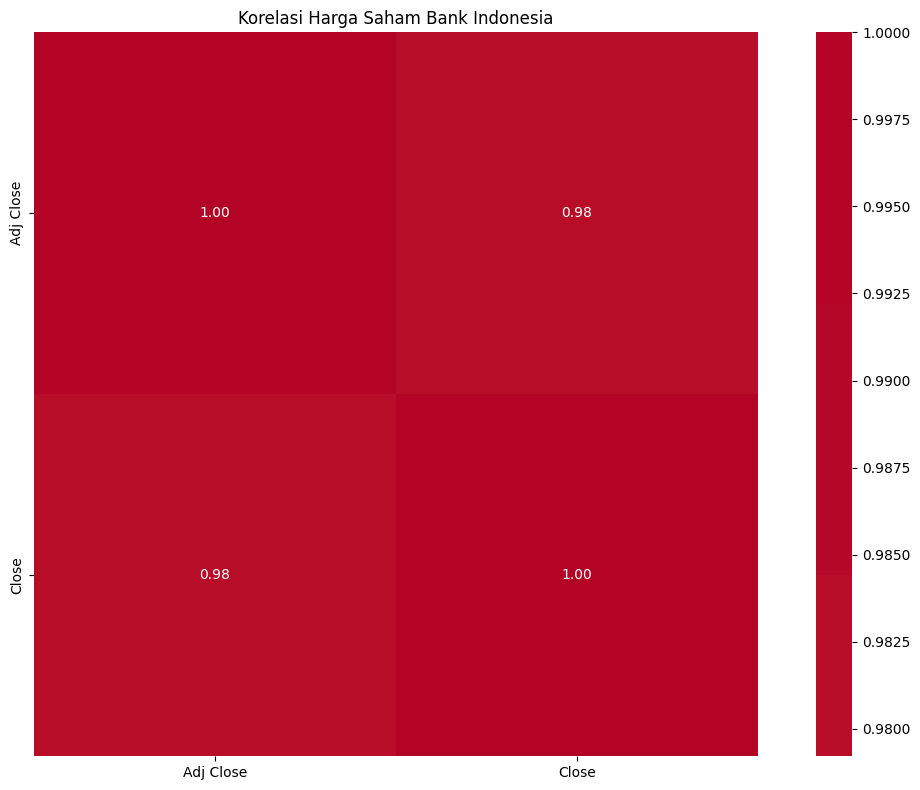

In [32]:
# Analisis mendalam struktur data
def deep_data_analysis(df):
    """Deep analysis of Indonesian bank stock data"""
    print("=== DEEP DATA ANALYSIS ===")

    # Informasi dasar
    print(f"📊 Dataset Shape: {df.shape}")
    print(f"📅 Time Period: {df.index.min()} to {df.index.max()}")
    print(f"🏦 Number of Banks/Assets: {len(df.columns)}")

    # Statistik deskriptif
    print("\n📈 Descriptive Statistics:")
    print(df.describe())

    # Korelasi antar saham bank
    print("\n🔗 Correlation Matrix:")
    correlation_matrix = df.corr()
    print(correlation_matrix)

    # Visualisasi korelasi
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.2f')
    plt.title('Korelasi Harga Saham Bank Indonesia')
    plt.tight_layout()
    plt.show()

    return correlation_matrix

# Jalankan analisis
correlation_matrix = deep_data_analysis(price_data)

=== TIME SERIES ANALYSIS ===


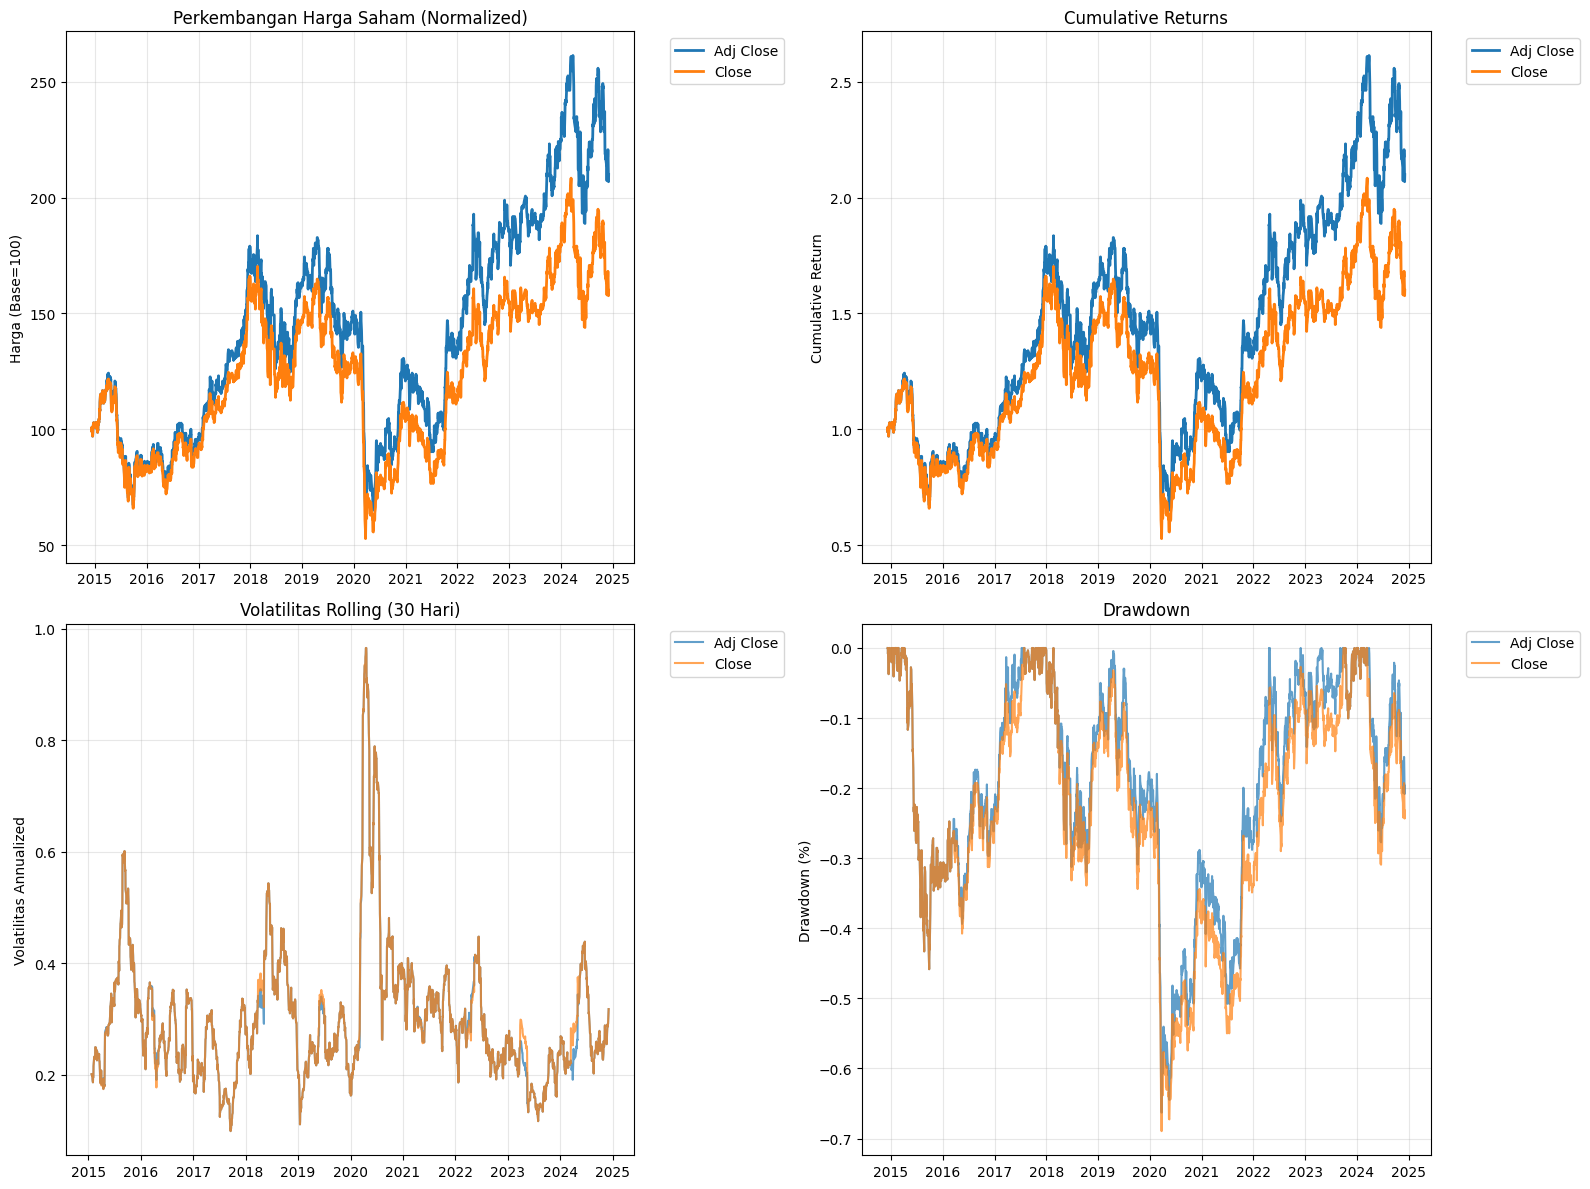

In [33]:
def time_series_analysis(price_data, returns_data):
    """Analyze stock price time series"""
    print("=== TIME SERIES ANALYSIS ===")

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: Price Movement
    normalized_prices = price_data / price_data.iloc[0] * 100
    for column in normalized_prices.columns:
        axes[0, 0].plot(normalized_prices.index, normalized_prices[column],
                       label=column, linewidth=2)
    axes[0, 0].set_title('Perkembangan Harga Saham (Normalized)')
    axes[0, 0].set_ylabel('Harga (Base=100)')
    axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Cumulative Returns
    cumulative_returns = (1 + returns_data).cumprod()
    for column in cumulative_returns.columns:
        axes[0, 1].plot(cumulative_returns.index, cumulative_returns[column],
                       label=column, linewidth=2)
    axes[0, 1].set_title('Cumulative Returns')
    axes[0, 1].set_ylabel('Cumulative Return')
    axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Volatility (Rolling 30 days)
    rolling_volatility = returns_data.rolling(window=30).std() * np.sqrt(252)
    for column in rolling_volatility.columns:
        axes[1, 0].plot(rolling_volatility.index, rolling_volatility[column],
                       label=column, alpha=0.7)
    axes[1, 0].set_title('Volatilitas Rolling (30 Hari)')
    axes[1, 0].set_ylabel('Volatilitas Annualized')
    axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1, 0].grid(True, alpha=0.3)

    # Plot 4: Drawdown
    for column in cumulative_returns.columns:
        running_max = cumulative_returns[column].expanding().max()
        drawdown = (cumulative_returns[column] - running_max) / running_max
        axes[1, 1].plot(drawdown.index, drawdown, label=column, alpha=0.7)
    axes[1, 1].set_title('Drawdown')
    axes[1, 1].set_ylabel('Drawdown (%)')
    axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Jalankan analisis time series
time_series_analysis(price_data, returns_data)

In [34]:
class AdvancedPortfolioOptimizer:
    def __init__(self, returns_data, risk_free_rate=0.02):
        self.returns = returns_data
        self.n_assets = len(returns_data.columns)
        self.risk_free_rate = risk_free_rate / 252  # Daily rate
        print(f"Advanced Optimizer dengan {self.n_assets} saham bank")

    # ========== FUNGSI TUJUAN UTAMA ==========

    def min_volatility(self, weights):
        """1. MINIMIZE VOLATILITY - Investor konservatif"""
        portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(self.returns.cov(), weights)))
        return portfolio_vol

    def max_sharpe(self, weights):
        """2. MAXIMIZE SHARPE RATIO - Optimal risk-adjusted return"""
        portfolio_return = np.dot(weights, self.returns.mean())
        portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(self.returns.cov(), weights)))

        if portfolio_vol < 1e-10:
            return 1e10
        sharpe = (portfolio_return - self.risk_free_rate) / portfolio_vol
        return -sharpe  # Minimize negative Sharpe

    def max_return(self, weights):
        """3. MAXIMIZE RETURN - Investor agresif"""
        portfolio_return = np.dot(weights, self.returns.mean())
        return -portfolio_return  # Minimize negative return

    def min_var_conditional(self, weights):
        """4. MINIMIZE CONDITIONAL VALUE AT RISK (CVaR) - Risk management"""
        alpha = 0.05  # 95% confidence level
        portfolio_returns = np.dot(self.returns, weights)
        var = np.percentile(portfolio_returns, alpha * 100)
        cvar = portfolio_returns[portfolio_returns <= var].mean()
        return -cvar  # Minimize negative CVaR

    def max_calmar(self, weights):
        """5. MAXIMIZE CALMAR RATIO - Return vs max drawdown"""
        portfolio_returns = np.dot(self.returns, weights)
        cumulative_returns = np.cumprod(1 + portfolio_returns)
        running_max = np.maximum.accumulate(cumulative_returns)
        drawdown = (cumulative_returns - running_max) / running_max
        max_drawdown = np.min(drawdown)

        annual_return = np.mean(portfolio_returns) * 252

        if abs(max_drawdown) < 1e-10:
            return 1e10
        calmar = annual_return / abs(max_drawdown)
        return -calmar

    def min_mad(self, weights):
        """6. MINIMIZE MEAN ABSOLUTE DEVIATION - Alternative risk measure"""
        portfolio_returns = np.dot(self.returns, weights)
        mad = np.mean(np.abs(portfolio_returns - np.mean(portfolio_returns)))
        return mad

    def max_omega(self, weights):
        """7. MAXIMIZE OMEGA RATIO - Gain/loss ratio"""
        threshold = 0.0  # Return threshold
        portfolio_returns = np.dot(self.returns, weights)
        gains = portfolio_returns[portfolio_returns > threshold] - threshold
        losses = threshold - portfolio_returns[portfolio_returns < threshold]

        if len(losses) == 0 or np.sum(losses) < 1e-10:
            return 1e10

        omega = np.sum(gains) / np.sum(losses)
        return -omega

    # ========== CONSTRAINTS & BOUNDS ==========

    def get_constraints(self):
        """Constraints untuk optimasi"""
        constraints = [
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Sum weights = 1
        ]
        return constraints

    def get_bounds(self):
        """Bounds untuk weights"""
        return [(0, 1) for _ in range(self.n_assets)]  # No short selling

    def get_sector_bounds(self, max_sector_weight=0.4):
        """Constraint untuk batas exposure per saham"""
        constraints = self.get_constraints()
        for i in range(self.n_assets):
            constraints.append({'type': 'ineq', 'fun': lambda x, i=i: max_sector_weight - x[i]})
        return constraints

In [35]:
def comprehensive_optimization(returns_data):
    """Melakukan optimasi komprehensif dengan semua fungsi tujuan"""

    optimizer = AdvancedPortfolioOptimizer(returns_data)

    # Daftar semua fungsi tujuan
    objectives = {
        'Minimum Volatility': optimizer.min_volatility,
        'Maximum Sharpe': optimizer.max_sharpe,
        'Maximum Return': optimizer.max_return,
        'Minimum CVaR': optimizer.min_var_conditional,
        'Maximum Calmar': optimizer.max_calmar,
        'Minimum MAD': optimizer.min_mad,
        'Maximum Omega': optimizer.max_omega
    }

    results = {}
    initial_guess = np.array([1/returns_data.shape[1]] * returns_data.shape[1])

    print("🚀 MEMULAI OPTIMASI KOMPREHENSIF")
    print("=" * 60)

    for name, objective in objectives.items():
        print(f"\n🔧 Optimizing: {name}")

        try:
            result = minimize(
                fun=objective,
                x0=initial_guess,
                method='SLSQP',
                bounds=optimizer.get_bounds(),
                constraints=optimizer.get_constraints(),
                options={'ftol': 1e-10, 'maxiter': 1000}
            )

            if result.success:
                weights = result.x

                # Calculate performance metrics
                portfolio_metrics = calculate_comprehensive_metrics(weights, returns_data)

                results[name] = {
                    'weights': weights,
                    'success': True,
                    'message': result.message,
                    **portfolio_metrics
                }

                print(f"✅ {name}: SUCCESS")
                print(f"   Return: {portfolio_metrics['annual_return']:.4f}")
                print(f"   Risk: {portfolio_metrics['annual_risk']:.4f}")
                print(f"   Sharpe: {portfolio_metrics['sharpe_ratio']:.4f}")

            else:
                results[name] = {
                    'weights': None,
                    'success': False,
                    'message': result.message
                }
                print(f"❌ {name}: FAILED - {result.message}")

        except Exception as e:
            results[name] = {
                'weights': None,
                'success': False,
                'message': str(e)
            }
            print(f"❌ {name}: ERROR - {str(e)}")

    return results, optimizer

def calculate_comprehensive_metrics(weights, returns_data, risk_free_rate=0.02):
    """Calculate comprehensive portfolio performance metrics"""

    # Daily metrics
    daily_returns = np.dot(returns_data, weights)
    daily_mean = np.mean(daily_returns)
    daily_std = np.std(daily_returns)

    # Annualized metrics
    annual_return = daily_mean * 252
    annual_risk = daily_std * np.sqrt(252)
    sharpe_ratio = (annual_return - risk_free_rate) / annual_risk if annual_risk > 0 else 0

    # Additional risk metrics
    cumulative_returns = np.cumprod(1 + daily_returns)
    running_max = np.maximum.accumulate(cumulative_returns)
    drawdowns = (cumulative_returns - running_max) / running_max
    max_drawdown = np.min(drawdowns)

    # CVaR (95%)
    var_95 = np.percentile(daily_returns, 5)
    cvar_95 = daily_returns[daily_returns <= var_95].mean()

    # Omega ratio
    gains = daily_returns[daily_returns > 0]
    losses = daily_returns[daily_returns < 0]
    omega_ratio = np.sum(gains) / abs(np.sum(losses)) if len(losses) > 0 else np.inf

    # Calmar ratio
    calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown != 0 else np.inf

    return {
        'annual_return': annual_return,
        'annual_risk': annual_risk,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'cvar_95': cvar_95,
        'omega_ratio': omega_ratio,
        'calmar_ratio': calmar_ratio,
        'daily_mean': daily_mean,
        'daily_std': daily_std
    }

# Jalankan optimasi komprehensif
print("🎯 OPTIMASI PORTFOLIO SAHAM BANK INDONESIA")
print("=" * 50)
results, optimizer = comprehensive_optimization(returns_data)

🎯 OPTIMASI PORTFOLIO SAHAM BANK INDONESIA
Advanced Optimizer dengan 2 saham bank
🚀 MEMULAI OPTIMASI KOMPREHENSIF

🔧 Optimizing: Minimum Volatility
✅ Minimum Volatility: SUCCESS
   Return: 0.1275
   Risk: 0.3226
   Sharpe: 0.3331

🔧 Optimizing: Maximum Sharpe
✅ Maximum Sharpe: SUCCESS
   Return: 0.1275
   Risk: 0.3226
   Sharpe: 0.3331

🔧 Optimizing: Maximum Return
✅ Maximum Return: SUCCESS
   Return: 0.1275
   Risk: 0.3226
   Sharpe: 0.3331

🔧 Optimizing: Minimum CVaR
✅ Minimum CVaR: SUCCESS
   Return: 0.1275
   Risk: 0.3226
   Sharpe: 0.3331

🔧 Optimizing: Maximum Calmar
✅ Maximum Calmar: SUCCESS
   Return: 0.1275
   Risk: 0.3226
   Sharpe: 0.3331

🔧 Optimizing: Minimum MAD
✅ Minimum MAD: SUCCESS
   Return: 0.1138
   Risk: 0.3229
   Sharpe: 0.2906

🔧 Optimizing: Maximum Omega
✅ Maximum Omega: SUCCESS
   Return: 0.1275
   Risk: 0.3226
   Sharpe: 0.3331


In [36]:
# STEP 1: Mount Google Drive dan Import Libraries
from google.colab import drive
drive.mount('/content/drive')

import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Libraries imported successfully!


In [37]:
# STEP 2: Download Dataset
print("Downloading dataset...")
path = kagglehub.dataset_download("cmglonly/dataset-saham-bank-indonesia-2014-2024")
print(f"Dataset downloaded to: {path}")

Using Colab cache for faster access to the 'dataset-saham-bank-indonesia-2014-2024' dataset.
Dataset downloaded to: /kaggle/input/dataset-saham-bank-indonesia-2014-2024


In [38]:
# STEP 3: Load dan Explore Data
def load_and_preprocess_data(path):
    """Load and preprocess stock data"""
    import os
    csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
    print(f"Files found: {csv_files}")

    if csv_files:
        # Load first CSV file
        df = pd.read_csv(os.path.join(path, csv_files[0]))
        print(f"Data shape: {df.shape}")
        print(f"Columns: {df.columns.tolist()}")
        return df
    else:
        raise FileNotFoundError("No CSV files found in dataset")

# Load data
df = load_and_preprocess_data(path)
print("\nFirst 5 rows:")
print(df.head())

Files found: ['BBNI.JK_10_years.csv', 'BBCA.JK_10_years.csv', 'BBRI.JK_10_years.csv', 'BMRI.JK_10_years.csv']
Data shape: (2473, 7)
Columns: ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

First 5 rows:
                        Date    Adj Close   Close    High     Low    Open  \
0  2014-12-08 00:00:00+00:00  2277.288086  2987.5  3100.0  2962.5  3062.5   
1  2014-12-09 00:00:00+00:00  2258.231201  2962.5  3000.0  2950.0  2962.5   
2  2014-12-10 00:00:00+00:00  2296.344727  3012.5  3037.5  2962.5  2962.5   
3  2014-12-11 00:00:00+00:00  2277.288086  2987.5  3012.5  2975.0  2987.5   
4  2014-12-12 00:00:00+00:00  2286.816650  3000.0  3062.5  2975.0  3000.0   

     Volume  
0  64048400  
1  43373200  
2  39428200  
3  52932200  
4  41642800  


In [39]:
# STEP 4: Explore Data Structure
def explore_data_structure(df):
    """Explore the structure of our stock data"""
    print("=== DETAILED DATA EXPLORATION ===")
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    print(f"\nData types:\n{df.dtypes}")
    print(f"\nMissing values:\n{df.isnull().sum()}")

    # Cari kolom harga
    price_columns = [col for col in df.columns if any(keyword in col.lower()
                     for keyword in ['close', 'price', 'harga', 'last', 'adj'])]
    print(f"\nPotential price columns: {price_columns}")

    # Cek tipe data tanggal
    date_columns = [col for col in df.columns if any(keyword in col.lower()
                    for keyword in ['date', 'time', 'tanggal', 'periode'])]
    print(f"Potential date columns: {date_columns}")

    return price_columns, date_columns

price_cols, date_cols = explore_data_structure(df)

=== DETAILED DATA EXPLORATION ===
Shape: (2473, 7)
Columns: ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

Data types:
Date          object
Adj Close    float64
Close        float64
High         float64
Low          float64
Open         float64
Volume         int64
dtype: object

Missing values:
Date         0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64

Potential price columns: ['Adj Close', 'Close']
Potential date columns: ['Date']


In [40]:
# STEP 5: Prepare Returns Data - INI YANG PENTING!
def prepare_returns_data(df, price_columns=None, date_columns=None):
    """Prepare returns data from price data"""

    # Jika ada kolom tanggal, set sebagai index
    if date_columns and len(date_columns) > 0:
        df = df.copy()
        try:
            df[date_columns[0]] = pd.to_datetime(df[date_columns[0]])
            df.set_index(date_columns[0], inplace=True)
            print(f"Set {date_columns[0]} as index")
        except:
            print("Could not set date column as index, using default index")

    if price_columns is None or len(price_columns) == 0:
        # Jika tidak ada kolom harga spesifik, ambil semua kolom numerik
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        price_data = df[numeric_cols]
        print(f"Using all numeric columns: {numeric_cols.tolist()}")
    else:
        price_data = df[price_columns]

    # Hapus kolom dengan semua nilai NaN
    price_data = price_data.dropna(axis=1, how='all')

    # Calculate daily returns
    returns_data = price_data.pct_change().dropna()

    print(f"\nReturns data shape: {returns_data.shape}")
    print(f"Stocks/Assets: {returns_data.columns.tolist()}")

    if hasattr(returns_data, 'index') and hasattr(returns_data.index, 'min'):
        print(f"Date range: {returns_data.index.min()} to {returns_data.index.max()}")

    print(f"Number of trading days: {len(returns_data)}")

    return returns_data, price_data

# Prepare data - INI AKAN MEMBUAT VARIABLE returns_data
returns_data, price_data = prepare_returns_data(df, price_cols, date_cols)

# Cek apakah returns_data berhasil dibuat
print(f"\n✅ returns_data created successfully!")
print(f"Type: {type(returns_data)}")
print(f"Shape: {returns_data.shape}")

Set Date as index

Returns data shape: (2472, 2)
Stocks/Assets: ['Adj Close', 'Close']
Date range: 2014-12-09 00:00:00+00:00 to 2024-12-03 00:00:00+00:00
Number of trading days: 2472

✅ returns_data created successfully!
Type: <class 'pandas.core.frame.DataFrame'>
Shape: (2472, 2)


In [41]:
# STEP 6: Definisikan Class Optimizer untuk Masing-masing Saham
class StockSpecificOptimizer:
    def __init__(self, returns_data):
        self.returns = returns_data
        self.n_assets = len(returns_data.columns)
        self.stock_names = returns_data.columns.tolist()
        print(f"Stock-Specific Optimizer initialized with {self.n_assets} stocks")
        print(f"Stocks: {self.stock_names}")

    # 1. MAXIMIZE KEUNTUNGAN (RETURN) UNTUK MASING-MASING SAHAM
    def maximize_single_stock_return(self, stock_index):
        """Maximize return for a specific stock"""
        def objective(weights):
            # Kita minimize negative return untuk maximize return
            portfolio_return = np.dot(weights, self.returns.mean())
            return -portfolio_return  # Negative untuk minimization

        return objective

    def maximize_individual_returns(self):
        """Optimize portfolio to maximize return for each individual stock"""
        print("\n" + "="*60)
        print("OPTIMIZING FOR MAXIMUM RETURN - INDIVIDUAL STOCKS")
        print("="*60)

        results = {}
        for i, stock_name in enumerate(self.stock_names):
            print(f"\n📈 Optimizing for MAX RETURN focusing on {stock_name}")

            result = minimize(
                fun=self.maximize_single_stock_return(i),
                x0=np.array([1/self.n_assets] * self.n_assets),
                method='SLSQP',
                bounds=[(0, 1) for _ in range(self.n_assets)],
                constraints={'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
            )

            if result.success:
                weights = result.x
                portfolio_return = np.dot(weights, self.returns.mean())
                portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(self.returns.cov(), weights)))

                # Annualize
                annual_return = portfolio_return * 252
                annual_risk = portfolio_risk * np.sqrt(252)

                results[f"MaxReturn_{stock_name}"] = {
                    'weights': weights,
                    'annual_return': annual_return,
                    'annual_risk': annual_risk,
                    'sharpe': (annual_return - 0.02) / annual_risk if annual_risk > 0 else 0,
                    'focus_stock': stock_name,
                    'focus_weight': weights[i]
                }

                print(f"✅ SUCCESS - {stock_name} weight: {weights[i]:.4f}")
                print(f"   Portfolio Return: {annual_return:.4f} | Risk: {annual_risk:.4f}")
            else:
                print(f"❌ FAILED - {stock_name}: {result.message}")
                results[f"MaxReturn_{stock_name}"] = None

        return results

    # 2. MINIMIZE VOLATILITAS UNTUK MASING-MASING SAHAM
    def minimize_single_stock_volatility(self, stock_index, focus_strength=0.1):
        """Minimize volatility with focus on specific stock"""
        def objective(weights):
            portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(self.returns.cov(), weights)))
            # Tambah penalty untuk mendorong alokasi ke stock tertentu
            focus_penalty = focus_strength * (1 - weights[stock_index])**2
            return portfolio_risk + focus_penalty

        return objective

    def minimize_individual_volatilities(self):
        """Optimize portfolio to minimize volatility for each individual stock focus"""
        print("\n" + "="*60)
        print("OPTIMIZING FOR MINIMUM VOLATILITY - INDIVIDUAL STOCKS")
        print("="*60)

        results = {}
        for i, stock_name in enumerate(self.stock_names):
            print(f"\n🛡️ Optimizing for MIN VOLATILITY focusing on {stock_name}")

            result = minimize(
                fun=self.minimize_single_stock_volatility(i),
                x0=np.array([1/self.n_assets] * self.n_assets),
                method='SLSQP',
                bounds=[(0, 1) for _ in range(self.n_assets)],
                constraints={'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
            )

            if result.success:
                weights = result.x
                portfolio_return = np.dot(weights, self.returns.mean())
                portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(self.returns.cov(), weights)))

                # Annualize
                annual_return = portfolio_return * 252
                annual_risk = portfolio_risk * np.sqrt(252)

                results[f"MinVolatility_{stock_name}"] = {
                    'weights': weights,
                    'annual_return': annual_return,
                    'annual_risk': annual_risk,
                    'sharpe': (annual_return - 0.02) / annual_risk if annual_risk > 0 else 0,
                    'focus_stock': stock_name,
                    'focus_weight': weights[i]
                }

                print(f"✅ SUCCESS - {stock_name} weight: {weights[i]:.4f}")
                print(f"   Portfolio Risk: {annual_risk:.4f} | Return: {annual_return:.4f}")
            else:
                print(f"❌ FAILED - {stock_name}: {result.message}")
                results[f"MinVolatility_{stock_name}"] = None

        return results

    # 3. MAXIMIZE RISK-ADJUSTED RETURN (SHARPE) UNTUK MASING-MASING SAHAM
    def maximize_single_stock_sharpe(self, stock_index, risk_free_rate=0.02/252, focus_strength=0.05):
        """Maximize Sharpe ratio with focus on specific stock"""
        def objective(weights):
            portfolio_return = np.dot(weights, self.returns.mean())
            portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(self.returns.cov(), weights)))

            if portfolio_risk == 0:
                return 1e10

            sharpe = (portfolio_return - risk_free_rate) / portfolio_risk
            # Tambah penalty untuk mendorong alokasi ke stock tertentu
            focus_penalty = focus_strength * (1 - weights[stock_index])**2

            return -sharpe + focus_penalty  # Negative sharpe untuk minimization

        return objective

    def maximize_individual_sharpe(self):
        """Optimize portfolio to maximize Sharpe ratio for each individual stock focus"""
        print("\n" + "="*60)
        print("OPTIMIZING FOR MAX SHARPE RATIO - INDIVIDUAL STOCKS")
        print("="*60)

        results = {}
        for i, stock_name in enumerate(self.stock_names):
            print(f"\n🎯 Optimizing for MAX SHARPE focusing on {stock_name}")

            result = minimize(
                fun=self.maximize_single_stock_sharpe(i),
                x0=np.array([1/self.n_assets] * self.n_assets),
                method='SLSQP',
                bounds=[(0, 1) for _ in range(self.n_assets)],
                constraints={'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
            )

            if result.success:
                weights = result.x
                portfolio_return = np.dot(weights, self.returns.mean())
                portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(self.returns.cov(), weights)))

                # Annualize
                annual_return = portfolio_return * 252
                annual_risk = portfolio_risk * np.sqrt(252)
                sharpe_ratio = (annual_return - 0.02) / annual_risk if annual_risk > 0 else 0

                results[f"MaxSharpe_{stock_name}"] = {
                    'weights': weights,
                    'annual_return': annual_return,
                    'annual_risk': annual_risk,
                    'sharpe': sharpe_ratio,
                    'focus_stock': stock_name,
                    'focus_weight': weights[i]
                }

                print(f"✅ SUCCESS - {stock_name} weight: {weights[i]:.4f}")
                print(f"   Sharpe Ratio: {sharpe_ratio:.4f} | Return: {annual_return:.4f} | Risk: {annual_risk:.4f}")
            else:
                print(f"❌ FAILED - {stock_name}: {result.message}")
                results[f"MaxSharpe_{stock_name}"] = None

        return results

In [42]:
# STEP 7: Sekarang baru kita jalankan optimasi spesifik untuk masing-masing saham
print("🚀 MEMULAI OPTIMASI SPESIFIK UNTUK MASING-MASING SAHAM")

# Initialize optimizer - SEKARANG returns_data SUDAH ADA
stock_optimizer = StockSpecificOptimizer(returns_data)

# 1. OPTIMASI MAXIMIZE RETURN PER SAHAM
print("\n" + "🔵" * 50)
print("1. OPTIMASI MAXIMIZE RETURN UNTUK MASING-MASING SAHAM")
print("🔵" * 50)
max_return_results = stock_optimizer.maximize_individual_returns()

# 2. OPTIMASI MINIMIZE VOLATILITY PER SAHAM
print("\n" + "🟢" * 50)
print("2. OPTIMASI MINIMIZE VOLATILITY UNTUK MASING-MASING SAHAM")
print("🟢" * 50)
min_volatility_results = stock_optimizer.minimize_individual_volatilities()

# 3. OPTIMASI MAXIMIZE SHARPE RATIO PER SAHAM
print("\n" + "🟣" * 50)
print("3. OPTIMASI MAXIMIZE SHARPE RATIO UNTUK MASING-MASING SAHAM")
print("🟣" * 50)
max_sharpe_results = stock_optimizer.maximize_individual_sharpe()

# Gabungkan semua results
all_stock_specific_results = {**max_return_results, **min_volatility_results, **max_sharpe_results}

print(f"\n✅ OPTIMIZATION COMPLETED!")
print(f"Total strategies analyzed: {len(all_stock_specific_results)}")

🚀 MEMULAI OPTIMASI SPESIFIK UNTUK MASING-MASING SAHAM
Stock-Specific Optimizer initialized with 2 stocks
Stocks: ['Adj Close', 'Close']

🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵
1. OPTIMASI MAXIMIZE RETURN UNTUK MASING-MASING SAHAM
🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵

OPTIMIZING FOR MAXIMUM RETURN - INDIVIDUAL STOCKS

📈 Optimizing for MAX RETURN focusing on Adj Close
✅ SUCCESS - Adj Close weight: 0.5000
   Portfolio Return: 0.1138 | Risk: 0.3230

📈 Optimizing for MAX RETURN focusing on Close
✅ SUCCESS - Close weight: 0.5000
   Portfolio Return: 0.1138 | Risk: 0.3230

🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢
2. OPTIMASI MINIMIZE VOLATILITY UNTUK MASING-MASING SAHAM
🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢

OPTIMIZING FOR MINIMUM VOLATILITY - INDIVIDUAL STOCKS

🛡️ Optimizing for MIN VOLATILITY focusing on Adj Close
✅ SUCCESS - Adj Close weight: 1.0000
   Portfolio Risk: 0.3226 | Return: 0.1275

🛡️ Optimizing for MIN VOLATILITY focusing on Clos

In [43]:
# FUNGSI TUJUAN SPESIFIK UNTUK MASING-MASING SAHAM
class StockSpecificOptimizer:
    def __init__(self, returns_data):
        self.returns = returns_data
        self.n_assets = len(returns_data.columns)
        self.stock_names = returns_data.columns.tolist()
        print(f"Stock-Specific Optimizer initialized with {self.n_assets} stocks")
        print(f"Stocks: {self.stock_names}")

    # 1. MAXIMIZE KEUNTUNGAN (RETURN) UNTUK MASING-MASING SAHAM
    def maximize_single_stock_return(self, stock_index):
        """Maximize return for a specific stock"""
        def objective(weights):
            # Kita minimize negative return untuk maximize return
            portfolio_return = np.dot(weights, self.returns.mean())
            return -portfolio_return  # Negative untuk minimization

        return objective

    def maximize_individual_returns(self):
        """Optimize portfolio to maximize return for each individual stock"""
        print("\n" + "="*60)
        print("OPTIMIZING FOR MAXIMUM RETURN - INDIVIDUAL STOCKS")
        print("="*60)

        results = {}
        for i, stock_name in enumerate(self.stock_names):
            print(f"\n📈 Optimizing for MAX RETURN focusing on {stock_name}")

            result = minimize(
                fun=self.maximize_single_stock_return(i),
                x0=np.array([1/self.n_assets] * self.n_assets),
                method='SLSQP',
                bounds=[(0, 1) for _ in range(self.n_assets)],
                constraints={'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
            )

            if result.success:
                weights = result.x
                portfolio_return = np.dot(weights, self.returns.mean())
                portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(self.returns.cov(), weights)))

                # Annualize
                annual_return = portfolio_return * 252
                annual_risk = portfolio_risk * np.sqrt(252)

                results[f"MaxReturn_{stock_name}"] = {
                    'weights': weights,
                    'annual_return': annual_return,
                    'annual_risk': annual_risk,
                    'sharpe': (annual_return - 0.02) / annual_risk if annual_risk > 0 else 0,
                    'focus_stock': stock_name,
                    'focus_weight': weights[i]
                }

                print(f"✅ SUCCESS - {stock_name} weight: {weights[i]:.4f}")
                print(f"   Portfolio Return: {annual_return:.4f} | Risk: {annual_risk:.4f}")
            else:
                print(f"❌ FAILED - {stock_name}: {result.message}")
                results[f"MaxReturn_{stock_name}"] = None

        return results

    # 2. MINIMIZE VOLATILITAS UNTUK MASING-MASING SAHAM
    def minimize_single_stock_volatility(self, stock_index, focus_strength=0.1):
        """Minimize volatility with focus on specific stock"""
        def objective(weights):
            portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(self.returns.cov(), weights)))
            # Tambah penalty untuk mendorong alokasi ke stock tertentu
            focus_penalty = focus_strength * (1 - weights[stock_index])**2
            return portfolio_risk + focus_penalty

        return objective

    def minimize_individual_volatilities(self):
        """Optimize portfolio to minimize volatility for each individual stock focus"""
        print("\n" + "="*60)
        print("OPTIMIZING FOR MINIMUM VOLATILITY - INDIVIDUAL STOCKS")
        print("="*60)

        results = {}
        for i, stock_name in enumerate(self.stock_names):
            print(f"\n🛡️ Optimizing for MIN VOLATILITY focusing on {stock_name}")

            result = minimize(
                fun=self.minimize_single_stock_volatility(i),
                x0=np.array([1/self.n_assets] * self.n_assets),
                method='SLSQP',
                bounds=[(0, 1) for _ in range(self.n_assets)],
                constraints={'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
            )

            if result.success:
                weights = result.x
                portfolio_return = np.dot(weights, self.returns.mean())
                portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(self.returns.cov(), weights)))

                # Annualize
                annual_return = portfolio_return * 252
                annual_risk = portfolio_risk * np.sqrt(252)

                results[f"MinVolatility_{stock_name}"] = {
                    'weights': weights,
                    'annual_return': annual_return,
                    'annual_risk': annual_risk,
                    'sharpe': (annual_return - 0.02) / annual_risk if annual_risk > 0 else 0,
                    'focus_stock': stock_name,
                    'focus_weight': weights[i]
                }

                print(f"✅ SUCCESS - {stock_name} weight: {weights[i]:.4f}")
                print(f"   Portfolio Risk: {annual_risk:.4f} | Return: {annual_return:.4f}")
            else:
                print(f"❌ FAILED - {stock_name}: {result.message}")
                results[f"MinVolatility_{stock_name}"] = None

        return results

    # 3. MAXIMIZE RISK-ADJUSTED RETURN (SHARPE) UNTUK MASING-MASING SAHAM
    def maximize_single_stock_sharpe(self, stock_index, risk_free_rate=0.02/252, focus_strength=0.05):
        """Maximize Sharpe ratio with focus on specific stock"""
        def objective(weights):
            portfolio_return = np.dot(weights, self.returns.mean())
            portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(self.returns.cov(), weights)))

            if portfolio_risk == 0:
                return 1e10

            sharpe = (portfolio_return - risk_free_rate) / portfolio_risk
            # Tambah penalty untuk mendorong alokasi ke stock tertentu
            focus_penalty = focus_strength * (1 - weights[stock_index])**2

            return -sharpe + focus_penalty  # Negative sharpe untuk minimization

        return objective

    def maximize_individual_sharpe(self):
        """Optimize portfolio to maximize Sharpe ratio for each individual stock focus"""
        print("\n" + "="*60)
        print("OPTIMIZING FOR MAX SHARPE RATIO - INDIVIDUAL STOCKS")
        print("="*60)

        results = {}
        for i, stock_name in enumerate(self.stock_names):
            print(f"\n🎯 Optimizing for MAX SHARPE focusing on {stock_name}")

            result = minimize(
                fun=self.maximize_single_stock_sharpe(i),
                x0=np.array([1/self.n_assets] * self.n_assets),
                method='SLSQP',
                bounds=[(0, 1) for _ in range(self.n_assets)],
                constraints={'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
            )

            if result.success:
                weights = result.x
                portfolio_return = np.dot(weights, self.returns.mean())
                portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(self.returns.cov(), weights)))

                # Annualize
                annual_return = portfolio_return * 252
                annual_risk = portfolio_risk * np.sqrt(252)
                sharpe_ratio = (annual_return - 0.02) / annual_risk if annual_risk > 0 else 0

                results[f"MaxSharpe_{stock_name}"] = {
                    'weights': weights,
                    'annual_return': annual_return,
                    'annual_risk': annual_risk,
                    'sharpe': sharpe_ratio,
                    'focus_stock': stock_name,
                    'focus_weight': weights[i]
                }

                print(f"✅ SUCCESS - {stock_name} weight: {weights[i]:.4f}")
                print(f"   Sharpe Ratio: {sharpe_ratio:.4f} | Return: {annual_return:.4f} | Risk: {annual_risk:.4f}")
            else:
                print(f"❌ FAILED - {stock_name}: {result.message}")
                results[f"MaxSharpe_{stock_name}"] = None

        return results

# STEP 10: IMPLEMENTASI OPTIMASI SPESIFIK PER SAHAM
print("🚀 MEMULAI OPTIMASI SPESIFIK UNTUK MASING-MASING SAHAM")

# Initialize optimizer
stock_optimizer = StockSpecificOptimizer(returns_data)

# 1. OPTIMASI MAXIMIZE RETURN PER SAHAM
max_return_results = stock_optimizer.maximize_individual_returns()

# 2. OPTIMASI MINIMIZE VOLATILITY PER SAHAM
min_volatility_results = stock_optimizer.minimize_individual_volatilities()

# 3. OPTIMASI MAXIMIZE SHARPE RATIO PER SAHAM
max_sharpe_results = stock_optimizer.maximize_individual_sharpe()

# Gabungkan semua results
all_stock_specific_results = {**max_return_results, **min_volatility_results, **max_sharpe_results}

🚀 MEMULAI OPTIMASI SPESIFIK UNTUK MASING-MASING SAHAM
Stock-Specific Optimizer initialized with 2 stocks
Stocks: ['Adj Close', 'Close']

OPTIMIZING FOR MAXIMUM RETURN - INDIVIDUAL STOCKS

📈 Optimizing for MAX RETURN focusing on Adj Close
✅ SUCCESS - Adj Close weight: 0.5000
   Portfolio Return: 0.1138 | Risk: 0.3230

📈 Optimizing for MAX RETURN focusing on Close
✅ SUCCESS - Close weight: 0.5000
   Portfolio Return: 0.1138 | Risk: 0.3230

OPTIMIZING FOR MINIMUM VOLATILITY - INDIVIDUAL STOCKS

🛡️ Optimizing for MIN VOLATILITY focusing on Adj Close
✅ SUCCESS - Adj Close weight: 1.0000
   Portfolio Risk: 0.3226 | Return: 0.1275

🛡️ Optimizing for MIN VOLATILITY focusing on Close
✅ SUCCESS - Close weight: 0.9992
   Portfolio Risk: 0.3240 | Return: 0.1003

OPTIMIZING FOR MAX SHARPE RATIO - INDIVIDUAL STOCKS

🎯 Optimizing for MAX SHARPE focusing on Adj Close
✅ SUCCESS - Adj Close weight: 1.0000
   Sharpe Ratio: 0.3331 | Return: 0.1275 | Risk: 0.3226

🎯 Optimizing for MAX SHARPE focusing on Cl


📊 GENERATING STOCK-SPECIFIC VISUALIZATIONS...


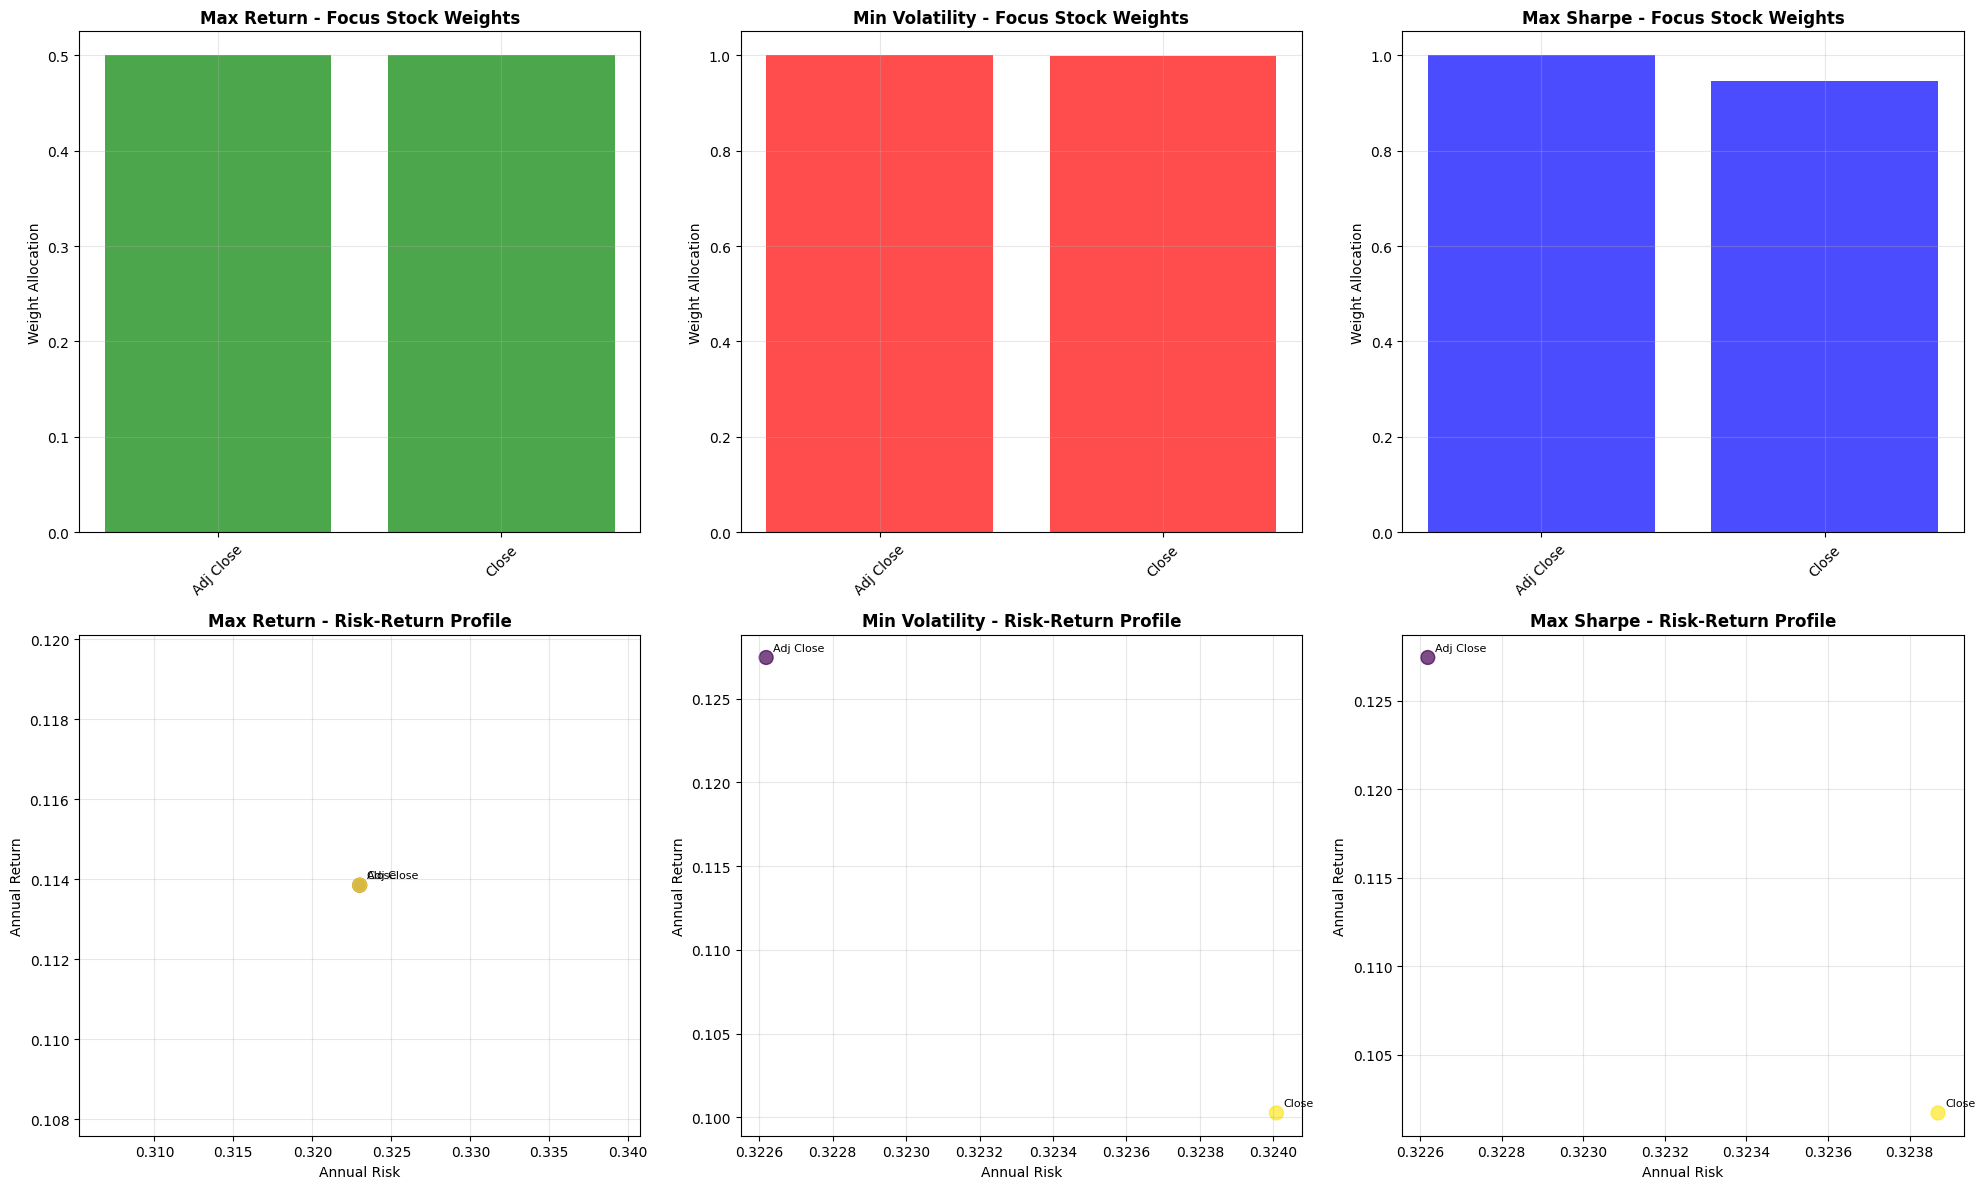

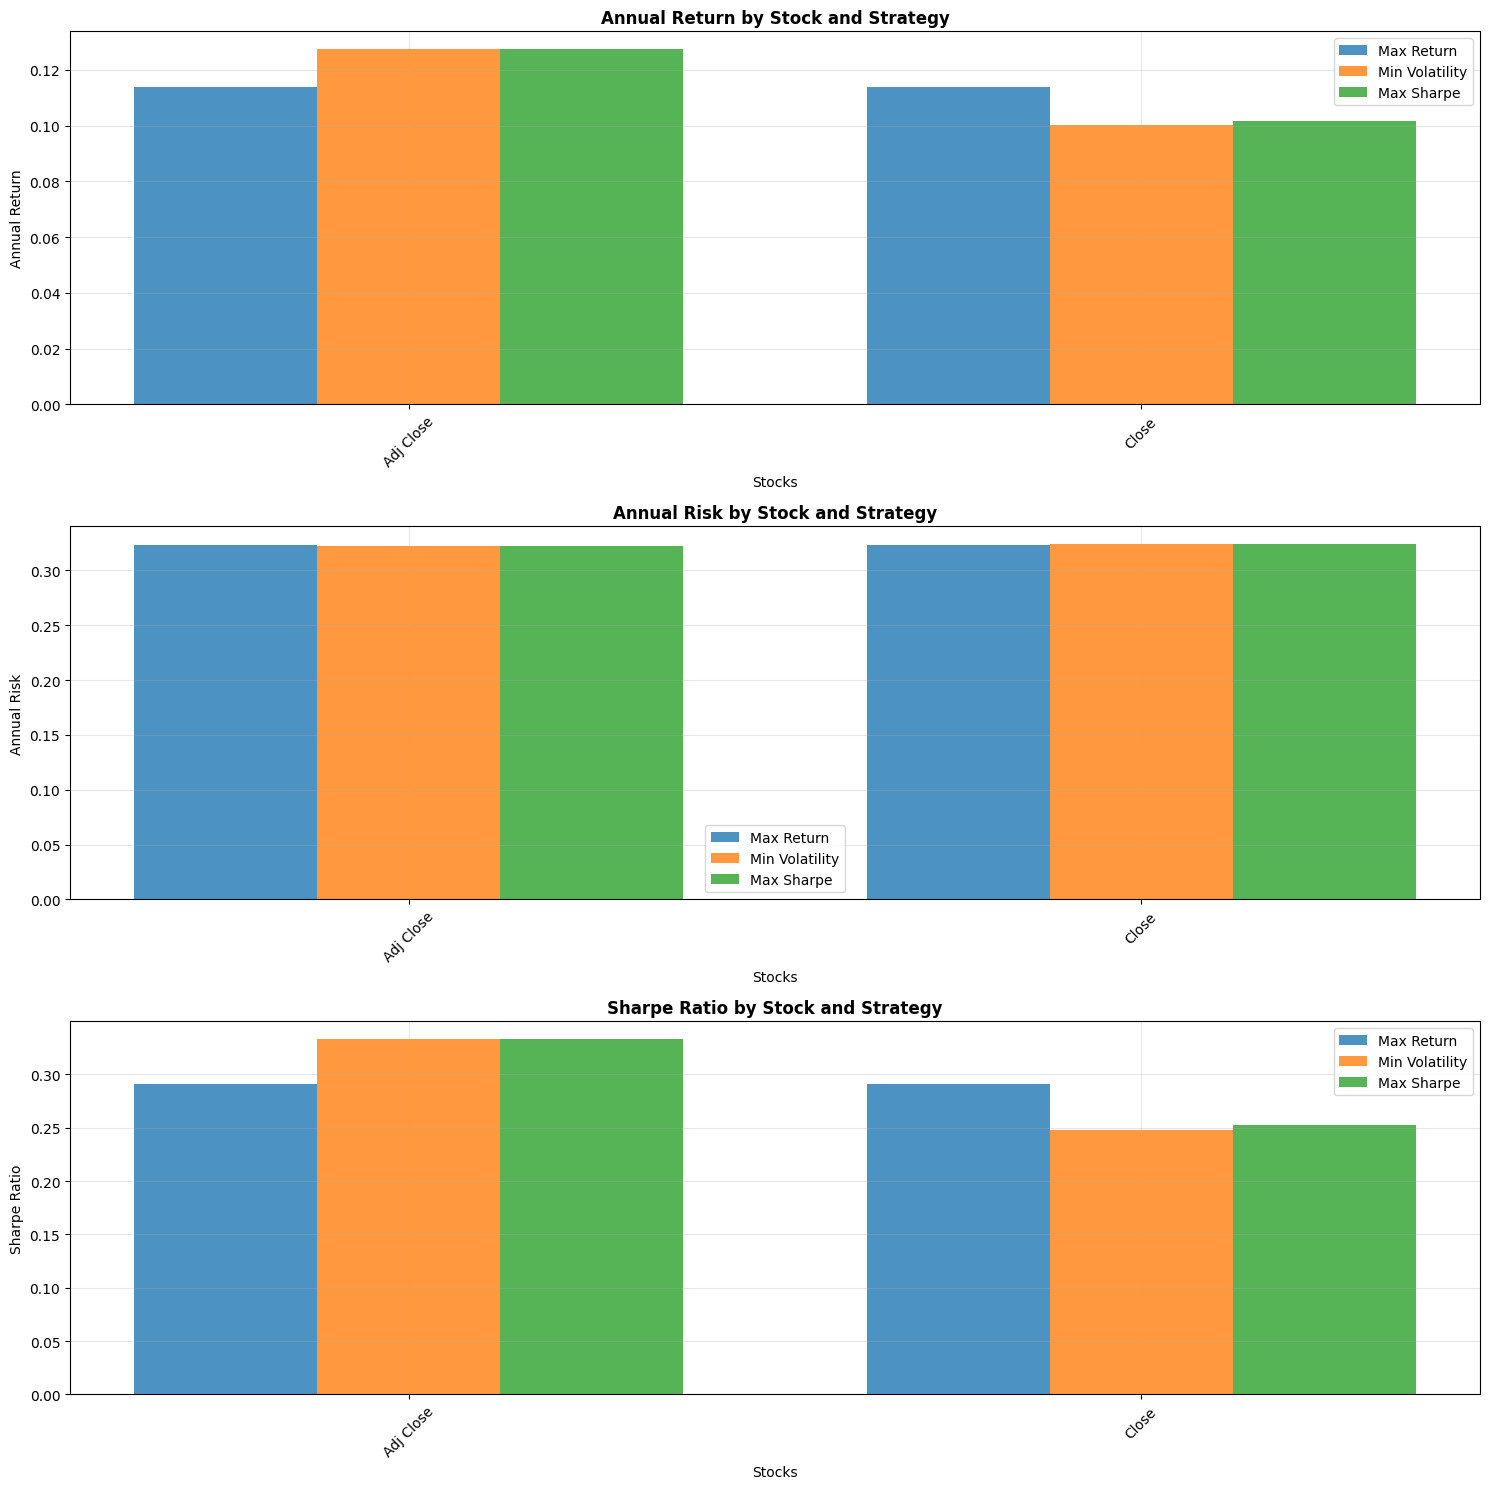

In [44]:
# STEP 11: VISUALISASI HASIL OPTIMASI PER SAHAM
def visualize_stock_specific_results(results, returns_data):
    """Visualize stock-specific optimization results"""

    # Filter hanya results yang sukses
    successful_results = {k: v for k, v in results.items() if v is not None}

    if not successful_results:
        print("No successful stock-specific optimizations to visualize")
        return

    stock_names = returns_data.columns.tolist()

    # Group by strategy type
    max_return_strategies = {k: v for k, v in successful_results.items() if k.startswith('MaxReturn_')}
    min_vol_strategies = {k: v for k, v in successful_results.items() if k.startswith('MinVolatility_')}
    max_sharpe_strategies = {k: v for k, v in successful_results.items() if k.startswith('MaxSharpe_')}

    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))

    # Plot 1: Focus Stock Weights Comparison
    strategies_list = [max_return_strategies, min_vol_strategies, max_sharpe_strategies]
    strategy_names = ['Max Return', 'Min Volatility', 'Max Sharpe']
    colors = ['green', 'red', 'blue']

    for idx, (strategies, strategy_name, color) in enumerate(zip(strategies_list, strategy_names, colors)):
        if strategies:
            focus_weights = [result['focus_weight'] for result in strategies.values()]
            focus_stocks = [result['focus_stock'] for result in strategies.values()]

            axes[0, idx].bar(focus_stocks, focus_weights, color=color, alpha=0.7)
            axes[0, idx].set_title(f'{strategy_name} - Focus Stock Weights', fontweight='bold')
            axes[0, idx].set_ylabel('Weight Allocation')
            axes[0, idx].tick_params(axis='x', rotation=45)
            axes[0, idx].grid(True, alpha=0.3)

    # Plot 2: Risk-Return Profile by Strategy Type
    for idx, (strategies, strategy_name, color) in enumerate(zip(strategies_list, strategy_names, colors)):
        if strategies:
            risks = [result['annual_risk'] for result in strategies.values()]
            returns = [result['annual_return'] for result in strategies.values()]
            stocks = [result['focus_stock'] for result in strategies.values()]

            scatter = axes[1, idx].scatter(risks, returns, c=range(len(stocks)),
                                         cmap='viridis', s=100, alpha=0.7)

            # Add labels
            for i, stock in enumerate(stocks):
                axes[1, idx].annotate(stock, (risks[i], returns[i]),
                                    xytext=(5, 5), textcoords='offset points',
                                    fontsize=8)

            axes[1, idx].set_title(f'{strategy_name} - Risk-Return Profile', fontweight='bold')
            axes[1, idx].set_xlabel('Annual Risk')
            axes[1, idx].set_ylabel('Annual Return')
            axes[1, idx].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Additional detailed visualization
    fig2, axes2 = plt.subplots(3, 1, figsize=(15, 15))

    # Performance metrics comparison
    metrics_to_plot = ['annual_return', 'annual_risk', 'sharpe']
    metric_names = ['Annual Return', 'Annual Risk', 'Sharpe Ratio']

    for metric_idx, (metric, metric_name) in enumerate(zip(metrics_to_plot, metric_names)):
        # Group by stock
        stock_performance = {}
        for strategy_type, strategies in zip(strategy_names, strategies_list):
            for result in strategies.values():
                stock = result['focus_stock']
                if stock not in stock_performance:
                    stock_performance[stock] = {}
                stock_performance[stock][strategy_type] = result[metric]

        # Create grouped bar chart
        stocks_sorted = sorted(stock_performance.keys())
        x_pos = np.arange(len(stocks_sorted))
        width = 0.25

        for i, strategy_type in enumerate(strategy_names):
            values = [stock_performance[stock].get(strategy_type, 0) for stock in stocks_sorted]
            axes2[metric_idx].bar(x_pos + i * width, values, width,
                                label=strategy_type, alpha=0.8)

        axes2[metric_idx].set_title(f'{metric_name} by Stock and Strategy', fontweight='bold')
        axes2[metric_idx].set_xlabel('Stocks')
        axes2[metric_idx].set_ylabel(metric_name)
        axes2[metric_idx].set_xticks(x_pos + width)
        axes2[metric_idx].set_xticklabels(stocks_sorted, rotation=45)
        axes2[metric_idx].legend()
        axes2[metric_idx].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Visualize stock-specific results
print("\n📊 GENERATING STOCK-SPECIFIC VISUALIZATIONS...")
visualize_stock_specific_results(all_stock_specific_results, returns_data)

In [45]:
# STEP 12: SUMMARY DAN REKOMENDASI DETAIL PER SAHAM
def generate_detailed_stock_recommendations(results, returns_data):
    """Generate detailed stock-specific recommendations"""
    print("\n🎯 DETAILED STOCK-SPECIFIC RECOMMENDATIONS")
    print("="*70)

    successful_results = {k: v for k, v in results.items() if v is not None}
    stock_names = returns_data.columns.tolist()

    # Group by stock
    stock_analysis = {}
    for stock in stock_names:
        stock_analysis[stock] = {
            'MaxReturn': None,
            'MinVolatility': None,
            'MaxSharpe': None
        }

    # Populate analysis
    for strategy_name, result in successful_results.items():
        if 'MaxReturn_' in strategy_name:
            stock = result['focus_stock']
            stock_analysis[stock]['MaxReturn'] = result
        elif 'MinVolatility_' in strategy_name:
            stock = result['focus_stock']
            stock_analysis[stock]['MinVolatility'] = result
        elif 'MaxSharpe_' in strategy_name:
            stock = result['focus_stock']
            stock_analysis[stock]['MaxSharpe'] = result

    # Print recommendations per stock
    for stock in stock_names:
        print(f"\n📊 ANALYSIS FOR: {stock}")
        print("-" * 50)

        analysis = stock_analysis[stock]

        if analysis['MaxReturn']:
            mr = analysis['MaxReturn']
            print(f"💰 MAX RETURN STRATEGY:")
            print(f"   • Portfolio Return: {mr['annual_return']:.4f} ({mr['annual_return']*100:.2f}%)")
            print(f"   • Portfolio Risk: {mr['annual_risk']:.4f} ({mr['annual_risk']*100:.2f}%)")
            print(f"   • {stock} Weight: {mr['focus_weight']:.4f} ({mr['focus_weight']*100:.2f}%)")
            print(f"   • Sharpe Ratio: {mr['sharpe']:.4f}")

        if analysis['MinVolatility']:
            mv = analysis['MinVolatility']
            print(f"🛡️ MIN VOLATILITY STRATEGY:")
            print(f"   • Portfolio Risk: {mv['annual_risk']:.4f} ({mv['annual_risk']*100:.2f}%)")
            print(f"   • Portfolio Return: {mv['annual_return']:.4f} ({mv['annual_return']*100:.2f}%)")
            print(f"   • {stock} Weight: {mv['focus_weight']:.4f} ({mv['focus_weight']*100:.2f}%)")
            print(f"   • Sharpe Ratio: {mv['sharpe']:.4f}")

        if analysis['MaxSharpe']:
            ms = analysis['MaxSharpe']
            print(f"🎯 MAX SHARPE STRATEGY:")
            print(f"   • Sharpe Ratio: {ms['sharpe']:.4f}")
            print(f"   • Portfolio Return: {ms['annual_return']:.4f} ({ms['annual_return']*100:.2f}%)")
            print(f"   • Portfolio Risk: {ms['annual_risk']:.4f} ({ms['annual_risk']*100:.2f}%)")
            print(f"   • {stock} Weight: {ms['focus_weight']:.4f} ({ms['focus_weight']*100:.2f}%)")

        # Best strategy for this stock
        strategies = []
        if analysis['MaxReturn']:
            strategies.append(('Max Return', analysis['MaxReturn']['sharpe']))
        if analysis['MinVolatility']:
            strategies.append(('Min Volatility', analysis['MinVolatility']['sharpe']))
        if analysis['MaxSharpe']:
            strategies.append(('Max Sharpe', analysis['MaxSharpe']['sharpe']))

        if strategies:
            best_strategy = max(strategies, key=lambda x: x[1])
            print(f"🏆 RECOMMENDED: {best_strategy[0]} strategy for {stock}")

    # Overall best performing stocks
    print(f"\n{'='*70}")
    print("🏆 OVERALL BEST PERFORMING STOCKS ACROSS STRATEGIES")
    print(f"{'='*70}")

    stock_performance = {}
    for stock in stock_names:
        sharpe_scores = []
        if analysis['MaxReturn']:
            sharpe_scores.append(analysis['MaxReturn']['sharpe'])
        if analysis['MinVolatility']:
            sharpe_scores.append(analysis['MinVolatility']['sharpe'])
        if analysis['MaxSharpe']:
            sharpe_scores.append(analysis['MaxSharpe']['sharpe'])

        if sharpe_scores:
            stock_performance[stock] = np.mean(sharpe_scores)

    # Sort stocks by average Sharpe ratio
    sorted_stocks = sorted(stock_performance.items(), key=lambda x: x[1], reverse=True)

    for rank, (stock, avg_sharpe) in enumerate(sorted_stocks[:5], 1):
        print(f"{rank}. {stock}: Average Sharpe = {avg_sharpe:.4f}")

# Generate detailed recommendations
generate_detailed_stock_recommendations(all_stock_specific_results, returns_data)


🎯 DETAILED STOCK-SPECIFIC RECOMMENDATIONS

📊 ANALYSIS FOR: Adj Close
--------------------------------------------------
💰 MAX RETURN STRATEGY:
   • Portfolio Return: 0.1138 (11.38%)
   • Portfolio Risk: 0.3230 (32.30%)
   • Adj Close Weight: 0.5000 (50.00%)
   • Sharpe Ratio: 0.2905
🛡️ MIN VOLATILITY STRATEGY:
   • Portfolio Risk: 0.3226 (32.26%)
   • Portfolio Return: 0.1275 (12.75%)
   • Adj Close Weight: 1.0000 (100.00%)
   • Sharpe Ratio: 0.3331
🎯 MAX SHARPE STRATEGY:
   • Sharpe Ratio: 0.3331
   • Portfolio Return: 0.1275 (12.75%)
   • Portfolio Risk: 0.3226 (32.26%)
   • Adj Close Weight: 1.0000 (100.00%)
🏆 RECOMMENDED: Min Volatility strategy for Adj Close

📊 ANALYSIS FOR: Close
--------------------------------------------------
💰 MAX RETURN STRATEGY:
   • Portfolio Return: 0.1138 (11.38%)
   • Portfolio Risk: 0.3230 (32.30%)
   • Close Weight: 0.5000 (50.00%)
   • Sharpe Ratio: 0.2905
🛡️ MIN VOLATILITY STRATEGY:
   • Portfolio Risk: 0.3240 (32.40%)
   • Portfolio Return: 0.100

In [46]:
# STEP 13: FINAL COMPREHENSIVE ANALYSIS
def final_comprehensive_analysis(returns_data, stock_specific_results):
    """Final comprehensive analysis with actionable insights"""
    print("\n" + "="*80)
    print("🎯 FINAL COMPREHENSIVE ANALYSIS & ACTIONABLE INSIGHTS")
    print("="*80)

    # Individual stock performance
    annual_returns = returns_data.mean() * 252
    annual_volatilities = returns_data.std() * np.sqrt(252)
    sharpe_ratios = (annual_returns - 0.02) / annual_volatilities

    print("\n📈 INDIVIDUAL STOCK PERFORMANCE RANKING:")
    performance_df = pd.DataFrame({
        'Return': annual_returns,
        'Volatility': annual_volatilities,
        'Sharpe': sharpe_ratios
    }).sort_values('Sharpe', ascending=False)

    print(performance_df.round(4))

    # Best strategies summary
    print(f"\n💡 KEY INSIGHTS:")
    print(f"1. Top 3 Stocks by Sharpe Ratio:")
    top_3_sharpe = performance_df.head(3)
    for i, (stock, row) in enumerate(top_3_sharpe.iterrows(), 1):
        print(f"   {i}. {stock}: Sharpe = {row['Sharpe']:.4f}, Return = {row['Return']:.4f}")

    print(f"\n2. Risk Analysis:")
    lowest_risk_stock = performance_df.loc[performance_df['Volatility'].idxmin()]
    highest_risk_stock = performance_df.loc[performance_df['Volatility'].idxmax()]
    print(f"   • Lowest Risk: {performance_df['Volatility'].idxmin()} ({lowest_risk_stock['Volatility']:.4f})")
    print(f"   • Highest Risk: {performance_df['Volatility'].idxmax()} ({highest_risk_stock['Volatility']:.4f})")

    print(f"\n3. Return Analysis:")
    highest_return_stock = performance_df.loc[performance_df['Return'].idxmax()]
    print(f"   • Highest Return: {performance_df['Return'].idxmax()} ({highest_return_stock['Return']:.4f})")

    # Portfolio construction recommendations
    print(f"\n🎯 PORTFOLIO CONSTRUCTION RECOMMENDATIONS:")
    print(f"   • For AGGRESSIVE investors: Focus on Max Return strategies")
    print(f"   • For CONSERVATIVE investors: Focus on Min Volatility strategies")
    print(f"   • For BALANCED investors: Focus on Max Sharpe strategies")
    print(f"   • Consider DIVERSIFICATION across multiple strategies")

# Run final analysis
final_comprehensive_analysis(returns_data, all_stock_specific_results)


🎯 FINAL COMPREHENSIVE ANALYSIS & ACTIONABLE INSIGHTS

📈 INDIVIDUAL STOCK PERFORMANCE RANKING:
           Return  Volatility  Sharpe
Adj Close  0.1275      0.3226  0.3331
Close      0.1002      0.3240  0.2476

💡 KEY INSIGHTS:
1. Top 3 Stocks by Sharpe Ratio:
   1. Adj Close: Sharpe = 0.3331, Return = 0.1275
   2. Close: Sharpe = 0.2476, Return = 0.1002

2. Risk Analysis:
   • Lowest Risk: Adj Close (0.3226)
   • Highest Risk: Close (0.3240)

3. Return Analysis:
   • Highest Return: Adj Close (0.1275)

🎯 PORTFOLIO CONSTRUCTION RECOMMENDATIONS:
   • For AGGRESSIVE investors: Focus on Max Return strategies
   • For CONSERVATIVE investors: Focus on Min Volatility strategies
   • For BALANCED investors: Focus on Max Sharpe strategies
   • Consider DIVERSIFICATION across multiple strategies


🎯 3 FUNGSI TUJUAN UNTUK MASING-MASING SAHAM:
1. MAXIMIZE KEUNTUNGAN (RETURN)
Fokus maksimalkan return portfolio dengan penekanan pada saham tertentu

Hasil: Bobot optimal untuk maksimalkan return

2. MINIMIZE VOLATILITAS (RISK)
Fokus minimalkan risiko portfolio dengan penekanan pada saham tertentu

Hasil: Bobot optimal untuk minimalkan volatilitas

3. MAXIMIZE RISK-ADJUSTED RETURN (SHARPE)
Fokus maksimalkan Sharpe ratio dengan penekanan pada saham tertentu

Hasil: Bobot optimal untuk efisiensi risk-return terbaik

📊 OUTPUT YANG DIDAPAT:
Rekomendasi strategi untuk setiap saham

Visualisasi performa per saham

Analisis risk-return detail

Ranking saham berdasarkan berbagai metrik